# 1) Notes: 

## THERE IS A "BUMP" IN MANTLE TEMPERATURE AT LATE TIMES WHEN USING THE EQUATION FOR Q(TAU_HEAT) FROM THE PAPER (I.E., tau_decay/(rho_m * c_p * T_ref/Q_0) INSTEAD OF THE SMOOTH EVOLUTION OF MANTLE TEMPERATURE IN TAD'S CODE USING (tau_decay/(rho_m * c_p * T_ref/F_0). COULD THIS BUMP BE REAL??? WHY DOES CHANGING THE NON-DIMENSIONAL TIMESCALE CAUSE THIS?
## --> INTERESTINGLY, THIS ONLY REMOVES THE BUMP WHEN THE TIMESCALE IS CHANGED IN THE EXPONENTIAL, WHILE THE REST OF THE EQUATION IS THE SAME AS IN THE PAPER.

## ACCORDING TO TAD, REGASSING CHECK IS "WONKY" -- FIGURE OUT A BETTER WAY TO DO THIS IN SIMPLE ANALYTIC MODEL (OR USE A MORE COMPLICATED MODEL, I.E. LAURA'S)

## TOTAL WATER MASS FRACTION VARYING WITH TIME FOR LOSS -- CHECK EACH FUNCTION THAT DEPENDS ON THE TOTAL VALUE, AND NOT JUST THE INITIAL VALUE!

# 2) XXXX Things to vary, once code runs with loss XXXX
## - total initial water [a) surface, b) interior]
## - water loss [c) rate, d) timescale]
## -- *Sensitivity Analysis*

# 3) XXXX Code Improvements XXXX
## - Laura's code
## - Better atmospheric loss (diffusion-limited escape; as opposed to energy-limited); accounting for planetary climate, atmospheric composition; wind-driven --> magnetic field --> mantle convection --> dynamo in outer core; hydrogen-generation --> photolysis of water and methane (our assumptions for now), OR serpentinization if iron-rich rock
## - Convection speed and regassing efficiency

In [15]:
%pylab inline
import math
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from pylab import *
from scipy.integrate import ode
#from mpl_toolkits.axes_grid.inset_locator import inset_axes

Populating the interactive namespace from numpy and matplotlib


/Users/admin/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['beta', 'fft', 'random', 'info', 'linalg', 'time', 'power']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
# Constants from Tad's code.
M_E = 5.972e24
R_E = 6.371e6
x_h = 0.05
rho_c = 3.e3
chi = 0.23
d_hE = 3e3
rho_m = 3.3e3
d_melt = 60.e3
f_degasE = 0.9
G = 6.67e-11
P_E = 4.e7
f_M = 0.68
f_b = 0.9
omega_0 = 2.3e-4
f_btwid = 1.3
year = 3.154e+7 #seconds per year
num_oceans = 1. #multiple of oceans compared to Earth, could use 1. or 10.
omg_Etwid = num_oceans*6.2e-4/2.3e-4 # from CA2014: omega/omega_0

In [3]:
# More constants from Tad's code.
E_a = 335.e3 #activation energy
R_g = 8.314 #gas constant
alpha = 2.e-5 #coefficent of thermal expansion
Ra_c = 1100. #critical Rayleigh number
kappa = 1.e-6 #mantle thermal diffusivity
T_ref = 1600. #reference temperature
#eta_0 = 1.e21
#eta_0 = 1.e16
#eta_0 = 9.03e24 # XXX CHANGE THIS LATER IF MASS OF PLANET CHANGES XXX
k = 4.2 #mantle thermal conductivity
beta = 0.3 #scaling exponent
c_p = 1200. #mantle heat capacity
Q_0 = 5.e-8
year = 3.154e7 #seconds per year

In [4]:
## WATER FUGACITY
# Need to calculate non-dimensional water fugacity at each step.
# Formula original from Li et al. (2008), based on experimental data.
def lnf_w(x_twid): #NOTE: Takes non-dimensionalized mantle water mass fraction and converts it.
    c0 = -7.9859
    c1 = 4.3559
    c2 = -0.5742
    c3 = 0.0337
    B = 2.0e6
    mu_oliv = 153.31
    mu_wat = 18.01528
    
    omega_0 = omega_0 = 2.3e-4
    f_btwid = 1.3
    f_M = 0.68
    
    x = x_twid*omega_0*f_btwid/f_M
    ln_term = np.log((B*x*(mu_oliv/mu_wat))/(1.-(x*(mu_oliv/mu_wat))))
    
    return c0 + c1*ln_term + c2*ln_term**2. + c3*ln_term**3.

def f_wtwid(x_twid):
    
    return np.exp(lnf_w(x_twid)) / (np.exp(lnf_w(1.)))

In [5]:
## MANTLE VISCOSITY

r_fug = 1.
eta_scale = (np.exp(lnf_w(1.)))**(-r_fug)
eta_0 = 1.e21/eta_scale

# Need a function to calculate the viscosity.
def eta(x_twid, T_twid): #x and T are non-dimensionalized later in code -- need to add dimensions back for these calculations
    E_a = 335.0e3
    R_g = 8.314
    r_fug = 1.
    eta_scale = (np.exp(lnf_w(1)))**(-r_fug)
    eta_0 = 1.e21/eta_scale
    
    x = x_twid * 2.3e-4 * 1.3 / 0.68 # mantle water mass fraction
    T = T_twid * 1600 #[K]
    
    f_w = np.exp(lnf_w(x_twid)) #lnf_w needs non-dimensionalized x
    
    eta_scale = (np.exp(lnf_w(1.)))**(-r_fug)
    eta_0 = 1.e21/eta_scale

    return eta_0 * (f_w**(-r_fug)) * np.exp((E_a/R_g)*((1./T) - (1./T_ref)))

In [6]:
def Rp(M):
    M_E = 5.972e24
    R_E = 6.371e6
    return R_E*(M/M_E)**0.27

def Rc(M):
    M_E = 5.972e24
    R_E = 6.371e6
    return 0.547*R_E*(M/M_E)**0.25

def h(M):
    return Rp(M) - Rc(M)

def g(M):
    G = 6.67e-11
    return G*M/(Rp(M)**2.)

def gtwid(M): #dimensionless gravity, normalized to Earth (FOR NOW)
    return g(M)/9.8

def A(M):
    return 4.*np.pi*(Rp(M)**2.)

def V(M):
    return (4.*np.pi/3.)*((Rp(M)**3.) - (Rc(M)**3.))

def F_0(M):
    T_ref = 1600.
    beta = 0.3
    alpha = 2.0e-5 #coefficent of thermal expansion
    rho_m = 3.3e3
    Ra_c = 1100. #critical Rayleigh number
    kappa = 1.0e-6 #mantle thermal diffusivity
    r_fug = 1.
    eta_scale = (np.exp(lnf_w(1.)))**(-r_fug)
    eta_0 = 1.e21/eta_scale

    f_w = np.exp(lnf_w(1.))
    return (k*(T_ref**(1.+beta))*A(M)/(h(M)*V(M)))*(alpha*rho_m*g(M)*(h(M)**3.)*f_w/(Ra_c*kappa*eta_0))**beta

def L_MOR(M):
    return 1.5*2.*np.pi*Rp(M)

def S(T_twid, x_twid, M):
    kappa = 1.0e-6
    beta = 0.3
    alpha = 2.0e-5
    rho_m = 3.3e3
    T_s = 280.
    Ra_c = 1100.
    
    x = x_twid * 2.3e-4 * 1.3 / 0.68 # mantle water mass fraction
    T = T_twid * 1600 #[K]
    
    return 10.76*(kappa**(1.-2.*beta))*(h(M)**(6.*beta-1.))*((alpha*rho_m*g(M)*(T-T_s)/(eta(x_twid,T_twid)*Ra_c))**(2.*beta))

def tau(M): #useful for converting between different non-dimensional timescales
    return (L_MOR(M)*(0.1/year)*x_h*rho_c*chi*d_hE)/(M*omega_0*f_btwid) #spreading rate independent of temp in this model

# Cowan & Abbot (CA) Model (Seafloor Pressure-Dependent)

In [9]:
# Take a step back for a second -- instead of numerically integrating at each timestep, just solve the equations using
# dx/dt and some chosen dt. Probably best to do this with a for loop. Based on CA model.
# Keep track of these things for subplots:
# 1) Reservoirs: mantle, surface [tons of water] (note: space technically a reservoir, but an infinite sink that cannot
# feed water back into the system)
# 2) Fluxes between reservoirs: regassing (surface to mantle), degassing (mantle to surface), loss to space (from surf)
# Start non-dimensional to be able to use Tad's equations, then convert before plotting.
# 3) Ratio of loss rates to the water in the reservoir in question 
## Another good thing to include would be how much water is moved at each timestep, based on fluxes at each timestep

# Timestep -- start large and reduce if the cycling seems too large.
dt = 1.0e-5 #1e-6 works --- very slow, and takes up almost all of my CPU -- INEFFICIENT!
t_max = 100.
#dt_heat_CA = (4.02*dt/2.87) #to calculate change in mantle temperature, for this model (different for SS and hybrid)

#Mass of planet -- CAN BE CHANGED LATER
M = M_E

# Create arrays for plotting. 
t_array_CA = np.arange(0., t_max, dt)  #time
x_array_CA = np.zeros(int(t_max/dt)) #mantle water mass fraction
s_array_CA = np.zeros(int(t_max/dt)) #surface water
T_array_CA = np.zeros(int(t_max/dt)) #mantle temperature
regas_array_CA = np.zeros(int(t_max/dt)) #regassing
degas_array_CA = np.zeros(int(t_max/dt)) #degassing
loss_array_CA = np.zeros(int(t_max/dt)) #loss to space

# Set constants.
omegatwid = 2.07 # total water mass fraction
#gtwid = g(M)/9.8 #dimensionless gravity, normalized to Earth (FOR NOW)
sigma = 1. #seafloor pressure regassing exponent
mu = 1. #seafloor pressure degassing exponent
tau_CA = 2.87e9 #non-dimensionalized time for CA model
Xtwid = x_h*rho_c*chi*d_hE*f_M/(rho_m*d_melt*f_degasE*omega_0*f_btwid) #1.32 #mantle degassing coefficient of Earth
t_loss = 1.0e8*year #e-folding timescale of 100 Myr 

# Mantle temperature calculation constants.
F_0twid = F_0(M)/Q_0 #0.531 #heat flux
beta = 0.3 #heat flux scaling coefficient
T_stwid = 280./1600. #surface temperature
T_mtwid = T_ref*R_g/(E_a) #another reference temperature
T_ref = 1600. #[K]
tau_decay = 2.0e9*year #radionuclide decay rate
tau_heat = Q_0/(rho_m*c_p*T_ref)

# Set initial values for reservoirs, and fluxes.
x_array_CA[0] = omegatwid/2.
s_array_CA[0] = omegatwid/2. # equally partitioned between the mantle and surface, initially 
T_array_CA[0] = 2.
regas_array_CA[0] = ((gtwid(M)**2.)*s_array_CA[0])**sigma
degas_array_CA[0] = (Xtwid**-1.)*x_array_CA[0]*((gtwid(M)**2.)*s_array_CA[0])**-mu
#const_loss = 1.0e-6
#loss_array[0] = #const_loss
#loss_factor = x_array[0] #initial value
loss_factor = 10.*degas_array_CA[0]
loss_array_CA[0] = loss_factor*np.exp(-(t_array_CA[0]*year/tau(M))/t_loss) #loss rate 10 times the degas rate
#loss_array[0] = loss_factor*(0.5)**(t_array[0]/t_loss) #same if no ln(2) in t_loss

# Now do the water cycling, using a for loop.
for idx in range(1, len(t_array_CA)): 
    
    # Calculate new values of mantle and surface water content.
    x_array_CA[idx] = x_array_CA[idx-1] + (regas_array_CA[idx-1] - degas_array_CA[idx-1])*dt #mantle cycling
    s_array_CA[idx] = s_array_CA[idx-1] + (degas_array_CA[idx-1] - regas_array_CA[idx-1])*dt #- loss_array_CA[idx-1])*dt #
    #surface cycling + loss, lose 1/2 ocean in 100 Myr (above)
               
# This uses equation (12) from the paper. -- Gives a bump in mantle temperature.    
#    T_array_CA[idx] = T_array_CA[idx-1] + (tau_heat/tau(M))*((np.exp(-(t_array_CA[idx-1]/tau(M))/tau_decay)) \
#        - (F_0twid*(f_wtwid(x_array_CA[idx-1])**beta)*((T_array_CA[idx-1]-T_stwid)**(beta+1.))*np.exp((-beta/T_mtwid)*((1./T_array_CA[idx-1])-1.))))*dt

    # Instead, this replicates Tad's code, using different non-dimensional time scaling (i.e., F_0 instead of Q_0).
    # XXXX ALSO MIGHT HAVE TO CHANGE INITIAL TAU_HEAT, MOVE F_0TWID VARIABLE AND MULTIPLY? XXXX
    T_array_CA[idx] = T_array_CA[idx-1] + (tau_heat/tau(M))*(np.exp(-t_array_CA[idx-1]/(tau_decay/(rho_m*c_p*T_ref/(F_0(M))))) \
        - (F_0twid*(f_wtwid(x_array_CA[idx-1])**beta)*((T_array_CA[idx-1]-T_stwid)**(beta+1.))*np.exp((-beta/T_mtwid)*((1./T_array_CA[idx-1])-1.))))*dt
       
       
    # If all water removed from reservoir, must set equal to zero.
    if x_array_CA[idx] <= 0.:
        x_array_CA[idx] = 0.
    elif s_array_CA[idx] <= 0.:
        s_array_CA[idx] = 0.
                                           
    f_w = np.exp(lnf_w(x_array_CA[idx]))/np.exp(lnf_w(1.)) #non-dimensional water fugacity

    # Calculate new regassing, degassing, and loss fluxes.
    if x_array_CA[idx] > 0. and s_array_CA[idx] > 0.: #water in both reservoirs
        regas_array_CA[idx] = ((gtwid(M)**2.)*s_array_CA[idx])**sigma
        degas_array_CA[idx] = (Xtwid**-1.)*x_array_CA[idx]*((gtwid(M)**2.)*s_array_CA[idx])**-mu
        loss_array_CA[idx] = loss_factor*np.exp(-(t_array_CA[idx]*year/tau(M))/t_loss)
    elif x_array_CA[idx] <= 0. and s_array_CA[idx] > 0.: #no degassing if no water in mantle
        regas_array_CA[idx] = ((gtwid(M)**2.)*s_array_CA[idx])**sigma
        degas_array_CA[idx] = 0.
        loss_array_CA[idx] = loss_factor*np.exp(-(t_array_CA[idx]*year/tau(M))/t_loss) # OR const_loss
    elif x_array_CA[idx] > 0. and s_array_CA[idx] <= 0: #no regassing if no water on surface (also no loss)
        regas_array_CA[idx] = 0.
        degas_array_CA[idx] = (Xtwid**-1.)*x_array_CA[idx]*((gtwid(M)**2.)*s_array_CA[idx])**-mu
        loss_array_CA[idx] = 0.
    elif x_array_CA[idx] <= 0. and s_array_CA[idx] <= 0.: #no degassing, no regassing, no loss --> DESSICATED
        regas_array_CA[idx] = 0.
        degas_array_CA[idx] = 0.
        loss_array_CA[idx] = 0.


In [ ]:
#CA_time = t_array_CA
#CA_x = x_array_CA
#CA_s = s_array_CA
#CA_r = regas_array_CA
#CA_d = degas_array_CA
#CA_T = T_array_CA

In [ ]:
#%store CA_time
#%store CA_x
#%store CA_s
#%store CA_d
#%store CA_T

In [ ]:
#print(T_array_CA[1] - T_array_CA[0])
#print(Q_0*tau(M)/(rho_m*c_p*T_ref))

#print((rho_m*c_p*T_ref*tau(M)/Q_0)*(np.exp(-(0./tau(M))/tau_decay)))
#print((rho_m*c_p*T_ref*tau(M)/Q_0)*(F_0twid*(f_w**beta)*((2.-T_s)**(beta+1.))*np.exp((-beta/T_m)*((1./2.)-1.))))
#print(Q_0/F_0(M_E))
#print(F_0(M_E)/Q_0)

In [10]:
time = 0.*2.87e9
M = M_E
f_w = np.exp(lnf_w(1.035))/np.exp(lnf_w(1.))
#print(((np.exp(-time/tau_decay)) - (F_0twid*(f_w**beta)*((T_array_CA[0]-T_s)**(beta+1.))*np.exp((-beta/T_m)*((1./T_array_CA[0])-1.))))*dt)
#print((rho_m*c_p*T_ref*tau(M)/Q_0)*((np.exp(-(0./tau(M))/tau_decay)) - (F_0twid*(f_w**beta)*((2.-T_s)**(beta+1.))*np.exp((-beta/T_m)*((1./2.)-1.))))*dt)


In [11]:
kg_conv = 2.3e-4*1.3*M_E #[kg]
print(x_array_CA[0], x_array_CA[0]*kg_conv, 'kg')
print(s_array_CA[0], s_array_CA[0]*kg_conv, 'kg')
dr_conv = (3*np.pi*(6.3781e6)*(0.1/31536000.)*0.05*3.0e3*0.23*3.0e3/0.68) #[kg/s]
print(degas_array_CA[0], degas_array_CA[0]*1.0e-5, degas_array_CA[0]*dr_conv*1.0e-5*2.87e9*31536000., 'kg/timestep')
print(regas_array_CA[0], regas_array_CA[0]*1.0e-5, regas_array_CA[0]*dr_conv*1.0e-5*2.87e9*31536000., 'kg/timestep')
print(loss_array_CA[0], loss_array_CA[0]*1.0e-5, loss_array_CA[0]*dr_conv*1.0e-5*2.87e9*31536000., 'kg/timestep')

1.035 1.84812498e+21 kg
1.035 1.84812498e+21 kg
0.7549547662687315 7.549547662687315e-06 1.9824247752858748e+16 kg/timestep
1.0378845427065349 1.037884542706535e-05 2.725365973271163e+16 kg/timestep
7.549547662687315 7.549547662687316e-05 1.982424775285875e+17 kg/timestep


/Users/admin/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


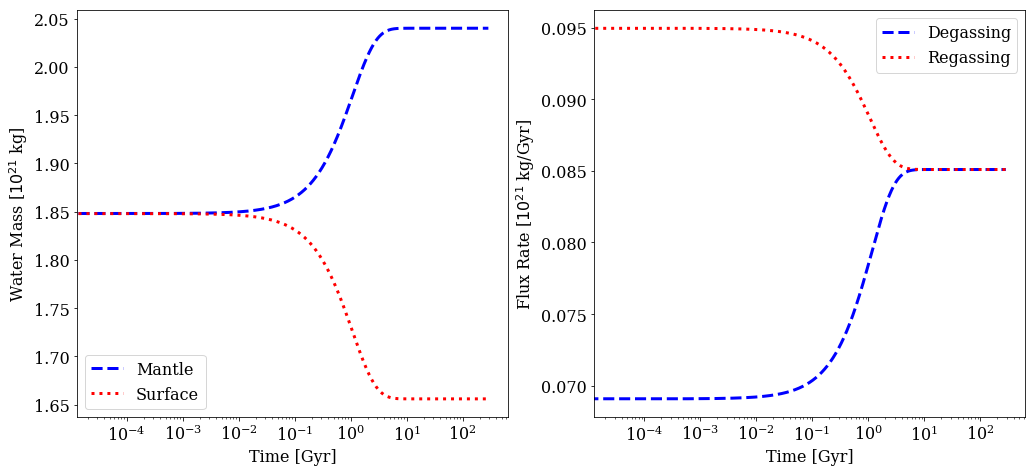

In [12]:
%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(17,7.5))
plt.tight_layout()
ax = [fig.add_subplot(1,2,i+1) for i in range(2)]
fig.subplots_adjust(hspace=0)

kg_conv = 2.3e-4*1.3*M_E #[kg] #IS THIS CORRECT? CHECK MASS FRACTIONS

ax = plt.subplot(1,2,1)
plt.semilogx(t_array_CA*2.87, (x_array_CA*kg_conv/1000./1.0e18), linewidth=3, color='b', linestyle='--', label='Mantle')
plt.semilogx(t_array_CA*2.87, (s_array_CA*kg_conv/1000./1.0e18), linewidth=3, color='r', linestyle=':', label='Surface')
#plt.semilogx([0., 287], [1.32*kg_conv/1000./1.0e18, 1.32*kg_conv/1000./1.0e18], color='k', linestyle='--', label='Earth Mantle Water')
#plt.semilogx([0., 287], [1.39, 1.39], color='k', linestyle=':', label='Earth Surface Water')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel(r'Water Mass [$10^{21}$ kg]', fontsize=16)
plt.legend(loc='lower left', fontsize=16)

# Conversion factor for degassing and regassing to units: (mass transport flux in [kg m^-2 s^-1])
# Literature tends to list global degassing rates in [mol yr^-1]; others simply use [g yr^1]; CA paper used [kg yr^-1]
# 1 mol H2O = 18.01528 g = 0.01801528 kg; 1 yr = 31536000 s
# Maybe try (10^18 tons)/(10^6 yr) = exatons/Myr
# degassing: (kg_conv**2)/(9.8**2)... 
# regassing: (kg_conv**2)/(9.8**2)
dr_conv = (3*np.pi*(6.3781e6)*(0.1/31536000.)*0.05*3.0e3*0.23*3.0e3/0.68) #[kg/s]
mol_yr_conv = (3153600./0.01801528) # convert [kg/s] to [mol/yr]
exa_gyr_conv = (3153600.*1.0e9/(1000.*1.0e18)) # convert [kg/s] to [exatons/Gyr]
# Mol/yr rate consistent with degassing rate of H2O from paper -- 6*10^12 mol/yr!

ax = plt.subplot(1,2,2)
plt.semilogx(t_array_CA*2.87, (degas_array_CA*dr_conv*exa_gyr_conv), linewidth=3, color='b', linestyle='--', label='Degassing')
plt.semilogx(t_array_CA*2.87, (regas_array_CA*dr_conv*exa_gyr_conv), linewidth=3, color='r', linestyle=':', label='Regassing')
#plt.semilogx(t_array_CA*2.87, (loss_array_CA*dr_conv*exa_gyr_conv), linewidth=3, color='k', linestyle='-.', label='Atmospheric Loss')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel(r'Flux Rate [$10^{21}$ kg/Gyr]', fontsize=16)
plt.legend(loc='upper right', fontsize=16)
plt.savefig('Recoded_CA_model_cycling_noloss.pdf', bbox_inches='tight')
#plt.savefig('Recoded_CA_model_cycling_exploss.pdf', bbox_inches='tight')


Text(0, 0.5, 'Mantle Temperature [K]')

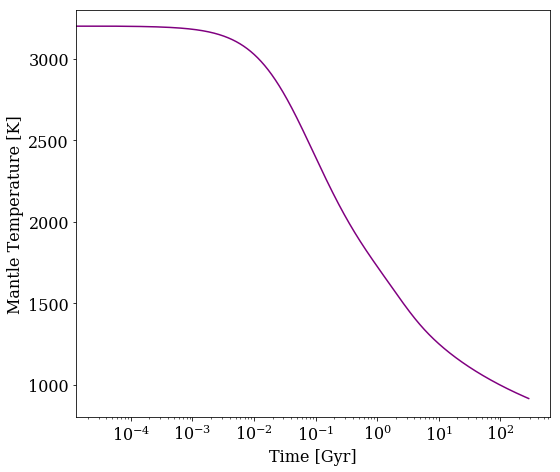

In [13]:
%matplotlib inline
fig = plt.figure(figsize=(8.5,7.5))
plt.semilogx(t_array_CA*2.87, T_array_CA*1600., color='purple')
plt.ylim([800,3300])
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel('Mantle Temperature [K]', fontsize=16)

In [ ]:
# Read in the mantle temp variables from Tad's code, for comparison.
#%store -r tmp_time_array
#%store -r tmp_temp_array

In [ ]:
#print(T_array_CA[-1]*1600.)

#%matplotlib inline
#fig = plt.figure(figsize=(8.5,7.5))
#plt.semilogx(tmp_time_array*2.87, tmp_temp_array*1600., color='purple')
#plt.semilogx(t_array_CA*2.87, T_array_CA*1600., color='purple', linestyle='--')
#plt.xlabel('Time [Gyr]', fontsize=16)
#plt.ylabel('Mantle Temperature [K]', fontsize=16)
#plt.savefig('Recoded_CA_Model_noloss_MantleTemp_Comparison.pdf')

In [ ]:
%matplotlib inline
fig = plt.figure(figsize=(8.5,7.5))
plt.semilogx(tmp_time_array*2.87, tmp_temp_array*1600.-T_array_CA*1600., color='purple', linestyle='-.')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel('Mantle Temperature [K]', fontsize=16)

In [ ]:
%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,7.5))
plt.tight_layout()

plt.semilogx(t_array_CA*2.87, (degas_array_CA*dr_conv*exa_gyr_conv), linewidth=3, color='b', linestyle='--', label='Degassing')
plt.semilogx(t_array_CA*2.87, (regas_array_CA*dr_conv*exa_gyr_conv), linewidth=3, color='r', linestyle=':', label='Regassing')
#plt.semilogx(t_array_CA*2.87, (loss_array_CA*dr_conv*exa_gyr_conv), linewidth=3, color='k', linestyle='-.', label='Atmospheric Loss')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel(r'Flux Rate [$10^{21}$ kg/Gyr]', fontsize=16)
plt.legend(loc='upper right', fontsize=16)
plt.savefig('Talk_Recoded_CA_model_cycling_exploss.pdf', bbox_inches='tight')

In [ ]:
# Also plot rates vs. the reservoir from which they are pulling, at each timestep.
# (This might require a step back of the above conversions.)
sec_timestep_conv = 2.87e-5*31536000.*1.0e9

degas_mantle_CA = np.divide((degas_array_CA*dr_conv*sec_timestep_conv), (x_array_CA*kg_conv), out=np.zeros_like(degas_array_CA), where=x_array_CA!=0)
regas_surface_CA = np.divide((regas_array_CA*dr_conv*sec_timestep_conv), (s_array_CA*kg_conv), out=np.zeros_like(regas_array_CA), where=s_array_CA!=0)
loss_surface_CA = np.divide((loss_array_CA*dr_conv*sec_timestep_conv), (s_array_CA*kg_conv), out=np.zeros_like(loss_array_CA), where=s_array_CA!=0)

%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8,7.5))
plt.tight_layout()
plt.semilogx(t_array_CA*2.87, degas_mantle_CA, linewidth=3, color='b', linestyle='--', label='Degassing')
plt.semilogx(t_array_CA*2.87, regas_surface_CA, linewidth=3, color='r', linestyle=':', label='Regassing')
plt.semilogx(t_array_CA*2.87, loss_surface_CA, linewidth=3, color='k', linestyle='-.', label='Atmospheric Loss')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel('Relative Transfer per Timestep', fontsize=16)
plt.legend(loc='upper right', fontsize=16)
plt.savefig('Recoded_CA_model_RelativeTransfer_cycling_exploss.pdf', bbox_inches='tight')


In [ ]:
print((x_array_CA[-1] + s_array_CA[-1])/ ((x_array_CA[0] + s_array_CA[0])))
print(s_array_CA[-1] / s_array_CA[0])

# CA Model, using scipy.integrate
## Function is stiff near reference temperature, so instead of the simple calculation of dx/dt, an adaptive timestep is required for when we get close to this value. scipy.optimize, with the integrator option 'vode', seems to be the best for this.

In [ ]:
# Define functions for change in 1) mantle temperature, 2) mantle water mass fraction, 3) surface water mass fraction.

def f_delta_temp_CA(t_twid, temp_twid, x_twid, M):
    Q_0 = 5.0e-8
    rho_m = 3.3e3
    c_p = 1200.
    T_ref = 1600.
    #tau_heat = Q_0/(rho_m*c_p*T_ref)
    
    #tau_decay = 2.0e9*3.154e7
    tau_decay_twid = 2.0e9*3.154e7/(rho_m*c_p*T_ref/F_0(M))
    F_0twid = F_0(M)/Q_0
    beta = 0.3
    T_stwid = 280./1600.
    
    R_g = 8.314
    E_a = 335.0e3
    T_mtwid = T_ref*R_g/(E_a)
    #(tau_heat/tau(M))* on the first term?
    return ((1./F_0twid)*np.exp(-t_twid/tau_decay_twid)) - \
        ((f_wtwid(x_twid)**beta)*((temp_twid-T_stwid)**(beta+1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)))

def f_delta_x_CA(t_twid, x_twid, s_twid, M):
    sigma = 1.
    mu = 1.
    
    x_h = 0.05
    rho_c = 3.0e3
    chi = 0.23
    d_hE = 3.0e3
    f_M = 0.68
    rho_m = 3.3e3
    d_melt = 60.0e3
    f_degasE = 0.9
    omega_0 = 2.3e-4
    f_btwid = 1.3
    Xtwid = x_h*rho_c*chi*d_hE*f_M/(rho_m*d_melt*f_degasE*omega_0*f_btwid)
    
    if x_twid > 0. and s_twid > 0.: #water in both reservoirs
        return ((gtwid(M)**2.)*s_twid)**sigma - (Xtwid**-1.)*x_twid*((gtwid(M)**2.)*s_twid)**(-mu)
    
    elif x_twid <= 0. and s_twid > 0.: #no degassing if no water in mantle
        return ((gtwid(M)**2.)*s_twid)**sigma - 0.
    
    elif x_twid > 0. and s_twid <= 0.: #no regassing if no water on surface
        return 0. - (Xtwid**-1.)*x_twid*((gtwid(M)**2.)*s_twid)**(-mu)
    
    else: #no degassing, no regassing
        return 0. - 0.
    
def f_delta_s_CA(t_twid, x_twid, s_twid, M):
    sigma = 1.
    mu = 1.
    
    x_h = 0.05
    rho_c = 3.0e3
    chi = 0.23
    d_hE = 3.0e3
    f_M = 0.68
    rho_m = 3.3e3
    d_melt = 60.0e3
    f_degasE = 0.9
    omega_0 = 2.3e-4
    f_btwid = 1.3
    Xtwid = x_h*rho_c*chi*d_hE*f_M/(rho_m*d_melt*f_degasE*omega_0*f_btwid)
    
    if x_twid > 0. and s_twid > 0.: #water in both reservoirs
        return (Xtwid**-1.)*x_twid*((gtwid(M)**2.)*s_twid)**(-mu) - ((gtwid(M)**2.)*s_twid)**sigma
    
    elif x_twid <= 0. and s_twid > 0.: #no degassing if no water in mantle
        return 0. - ((gtwid(M)**2.)*s_twid)**sigma
    
    elif x_twid > 0. and s_twid <= 0.: #no regassing if no water on surface
        return (Xtwid**-1.)*x_twid*((gtwid(M)**2.)*s_twid)**(-mu) - 0.
    
    else: #no degassing, no regassing
        return 0. - 0.
    

# Combine the change in temperature, x, and s into one cycling function to be integrated.
def f_cycling_CA(t_twid, z, M):
    temp_twid = z[0]
    x_twid = z[1]
    s_twid = z[2]
    #Q_0 = 5.0e-8
    #F_0twid = F_0(M)/Q_0
    rho_m = 3.3e3
    c_p = 1200.
    T_ref = 1600.
    
    return [(F_0(M)/(rho_m*c_p*T_ref*tau(M)))*f_delta_temp_CA(t_twid, temp_twid, x_twid, M), f_delta_x_CA(t_twid, x_twid, s_twid, M), f_delta_s_CA(t_twid, x_twid, s_twid, M)]

In [ ]:
# Define functions for regassing and degassing rates, at each step (water content-dependent).

def f_regas_CA(x_twid, s_twid, M):
    sigma = 1.
    
    if s_twid > 0.: #normal regassing
        return ((gtwid(M)**2.)*s_twid)**sigma
    else: #if s_twid <= 0; no regassing
        return 0.
    
def f_degas_CA(x_twid, s_twid, M):
    mu = 1.
    
    x_h = 0.05
    rho_c = 3.0e3
    chi = 0.23
    d_hE = 3.0e3
    f_M = 0.68
    rho_m = 3.3e3
    d_melt = 60.0e3
    f_degasE = 0.9
    omega_0 = 2.3e-4
    f_btwid = 1.3
    Xtwid = x_h*rho_c*chi*d_hE*f_M/(rho_m*d_melt*f_degasE*omega_0*f_btwid)
    
    if x_twid > 0.: #normal degassing
        return (Xtwid**-1.)*x_twid*((gtwid(M)**2.)*s_twid)**(-mu)
    else: #if x_twid <= 0.; no degassing
        return 0.

In [ ]:
# Set initial conditions.
omegatwid = omg_Etwid/(f_btwid)
t0 = 0.
z0 = [2., omegatwid/2., omegatwid/2.]
M = M_E

# Set up function to be integrated.
r = ode(f_cycling_CA).set_integrator('vode')
r.set_initial_value(z0, t0).set_f_params(M)

# Define max time, timestep, arrays to be filled within the integration loop.
t1 = 100.
dt = 1.e-5
t_array_CA = np.zeros(int(t1/dt)+1)
T_array_CA = np.zeros(int(t1/dt)+1)
x_array_CA = np.zeros(int(t1/dt)+1)
s_array_CA = np.zeros(int(t1/dt)+1)
regas_array_CA = np.zeros(int(t1/dt)+1)
degas_array_CA = np.zeros(int(t1/dt)+1)
#d_hydr_CA = np.zeros(int(t1/dt))
#eta_array_CA = np.zeros(int(t1/dt))

# Initial values in the arrays.
t_array_CA[0] = t0
T_array_CA[0] = z0[0]
x_array_CA[0] = z0[1]
s_array_CA[0] = z0[2]
regas_array_CA[0] = f_regas_CA(z0[1], z0[2], M)
degas_array_CA[0] = f_degas_CA(z0[1], z0[2], M)

# Integrate the above function.
idx = 1
while r.successful() and r.t < t1:
    r.integrate(r.t+dt)
    t_array_CA[idx] = r.t
    T_array_CA[idx] = r.y[0]
    x_array_CA[idx] = r.y[1]
    s_array_CA[idx] = r.y[2]
    regas_array_CA[idx] = f_regas_CA(r.y[1], r.y[2], M)
    degas_array_CA[idx] = f_degas_CA(r.y[1], r.y[2], M)
    idx = idx + 1

In [ ]:
%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(17,7.5))
plt.tight_layout()
fig = plt.figure(figsize=(8.5,7.5))
plt.semilogx(t_array_CA*2.87, T_array_CA*1600., color='purple')
plt.ylim([800,3300])
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel('Mantle Temperature [K]', fontsize=16)

In [ ]:
%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(17,7.5))
plt.tight_layout()
ax = [fig.add_subplot(1,2,i+1) for i in range(2)]
fig.subplots_adjust(hspace=0)

kg_conv = 2.3e-4*1.3*M_E #[kg] #IS THIS CORRECT? CHECK MASS FRACTIONS

ax = plt.subplot(1,2,1)
plt.semilogx(t_array_CA*2.87, (x_array_CA*kg_conv/1000./1.0e18), linewidth=3, color='b', linestyle='--', label='Mantle')
plt.semilogx(t_array_CA*2.87, (s_array_CA*kg_conv/1000./1.0e18), linewidth=3, color='r', linestyle=':', label='Surface')
#plt.semilogx([0., 287], [1.32*kg_conv/1000./1.0e18, 1.32*kg_conv/1000./1.0e18], color='k', linestyle='--', label='Earth Mantle Water')
#plt.semilogx([0., 287], [1.39, 1.39], color='k', linestyle=':', label='Earth Surface Water')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel(r'Water Mass [$10^{21}$ kg]', fontsize=16)
plt.legend(loc='lower left', fontsize=16)

# Conversion factor for degassing and regassing to units: (mass transport flux in [kg m^-2 s^-1])
# Literature tends to list global degassing rates in [mol yr^-1]; others simply use [g yr^1]; CA paper used [kg yr^-1]
# 1 mol H2O = 18.01528 g = 0.01801528 kg; 1 yr = 31536000 s
# Maybe try (10^18 tons)/(10^6 yr) = exatons/Myr
# degassing: (kg_conv**2)/(9.8**2)... 
# regassing: (kg_conv**2)/(9.8**2)
dr_conv = (3*np.pi*(6.3781e6)*(0.1/31536000.)*0.05*3.0e3*0.23*3.0e3/0.68) #[kg/s]
mol_yr_conv = (3153600./0.01801528) # convert [kg/s] to [mol/yr]
exa_gyr_conv = (3153600.*1.0e9/(1000.*1.0e18)) # convert [kg/s] to [exatons/Gyr]
# Mol/yr rate consistent with degassing rate of H2O from paper -- 6*10^12 mol/yr!

ax = plt.subplot(1,2,2)
plt.semilogx(t_array_CA*2.87, (degas_array_CA*dr_conv*exa_gyr_conv), linewidth=3, color='b', linestyle='--', label='Degassing')
plt.semilogx(t_array_CA*2.87, (regas_array_CA*dr_conv*exa_gyr_conv), linewidth=3, color='r', linestyle=':', label='Regassing')
#plt.semilogx(t_array_CA*2.87, (loss_array_CA*dr_conv*exa_gyr_conv), linewidth=3, color='k', linestyle='-.', label='Atmospheric Loss')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel(r'Flux Rate [$10^{21}$ kg/Gyr]', fontsize=16)
plt.legend(loc='upper right', fontsize=16)
#plt.savefig('Recoded_CA_model_cycling_noloss.pdf', bbox_inches='tight')
#plt.savefig('Recoded_CA_model_cycling_exploss.pdf', bbox_inches='tight')


# Schaefer & Sasselov (SS) Model (Mantle Temperature-Dependent)
# XXX TRY CODING THE DIMENSIONFUL VERSION OF THIS, SEE IF I CAN GET CLOSER TO TAD'S RESULTS THAT WAY XXX

In [ ]:
# Need a function to calculate the non-dimensional timescale of SS model.
chi_d = 0.03
chi_r = 0.02
theta = 1.5 #melt fraction exponent
T_liq_dry = 1225.+273.15
T_sol_dry = 975.+273.15
T_liqtwid = T_liq_dry/T_ref
T_soltwid = T_sol_dry/T_ref

Pi = (rho_m*d_melt*chi_d*(omega_0*f_btwid/f_M)*((T_liqtwid-T_soltwid)**-theta))

def D(M):
    x_h = 0.05
    rho_c = 3.0e3
    chi_r = 0.03
    beta = 0.3
    T_serp = 973.
    T_s = 280.
    T_ref = 1600.
    kappa = 1.0e-6
    Ra_c = 1100.
    eta_scale = (np.exp(lnf_w(1.)))**(-r_fug)
    eta_0 = 1.e21/eta_scale
    alpha = 2.0e-5
    rho_m = 3.3e3
    f_w = np.exp(lnf_w(1.))
    
    return x_h*rho_c*chi_r*(h(M)**(1.-3.*beta))*((T_serp-T_s)/(T_ref**(1.+beta)))*\
        (kappa*Ra_c*eta_0/(alpha*rho_m*g(M)*f_w))**beta

def Sigma(M):
    omega_0 = 2.3e-4
    f_btwid = 1.3
    beta = 0.3
    kappa = 1.0e-6
    Ra_c = 1100.
    eta_scale = (np.exp(lnf_w(1.)))**(-r_fug)
    eta_0 = 1.e21/eta_scale
    alpha = 2.0e-5
    rho_m = 3.3e3
    T_ref = 1600.
    
    f_w = np.exp(lnf_w(1.))
    
    return M*omega_0*f_btwid*((h(M)**(1.-6.*beta))*(kappa**(2.*beta-1.))/\
        (10.76*L_MOR(M)))*(Ra_c*eta_0/(alpha*rho_m*g(M)*T_ref*f_w))**(2.*beta)

def tau_SS(M):
    return D(M)/Sigma(M)

def Pitwid(M):
    rho_m = 3.3e3
    d_melt = 60.0e3
    chi_d = 0.02
    omega_0 = 2.3e-4
    f_btwid = 1.3
    f_M = 0.68
    T_ref = 1600.
    T_liqtwid = (1225.+273.15)/T_ref
    T_soltwid = (975.+273.15)/T_ref
    theta = 1.5
    
    Pi = (rho_m*d_melt*chi_d*(omega_0*f_btwid/f_M)*((T_liqtwid-T_soltwid)**-theta))
    return Pi/D(M)

def D_2_max(M, x_twid, s_twid, T_twid):
    omega_0 = 2.3e-4
    f_btwid = 1.3
    x_h = 0.05
    rho_m = 3.3e3
    beta = 0.3
    T_ref = 1600.
    R_g = 8.314
    E_a = 335.0e3
    T_mtwid = T_ref*R_g/(E_a)
    T_stwid = 280./1600.
    
    return (Rp(M)-(((Rp(M)**3.)-((3.*omega_0*f_btwid*M*s_twid)/(4*np.pi*x_h*rho_m)))**(1./3.)))*\
        np.exp((-beta/T_mtwid)*((1./T_twid)-1.))*(f_wtwid(x_twid)**beta)*((T_twid-T_stwid)**(1.+beta))

tau_heat = Q_0/(rho_m*c_p*T_ref)

In [ ]:
# Do the same as above, plotting the same things.
# Calculate the values used at each timestep and just multiply by dt.

# Timestep -- start large and reduce if the cycling seems too large.
dt = 1.0e-5
t_max = 100.
#dt_heat = (4.02*dt/2.22) #to calculate change in mantle temperature, for this model (different for CA and hybrid)

# Mass of planet
M = M_E

# Create arrays for plotting. 
t_array_SS = np.arange(0., t_max, dt)  #time
x_array_SS = np.zeros(int(t_max/dt)) #mantle water mass fraction
s_array_SS = np.zeros(int(t_max/dt)) #surface water
T_array_SS = np.zeros(int(t_max/dt)) #mantle temperature
regas_array_SS = np.zeros(int(t_max/dt)) #regassing
degas_array_SS = np.zeros(int(t_max/dt)) #degassing
loss_array_SS = np.zeros(int(t_max/dt)) #loss to space

# Set constants (non-dimensionalized, where necessary).
# These include constants in the thermal evolution, and constants in the actual cycling equation.
omegatwid = 2.07 #total water mass fraction
Q_0 = 5.0e-8
F_0twid = F_0(M)/Q_0
beta = 0.3 #heat flux scaling coefficient
T_ref = 1600. #[K]
T_s = 280. #surface temperature [K]
T_stwid = T_s/T_ref
T_mtwid = T_ref*R_g/(E_a) #another reference temperature
tau_decay = 2.0e9*year #radionuclide decay rate
#T_sol_dry = 0.780 #solidus temperature
#T_liq_dry = 0.936 #liquidus temperature
gamma = 0.75 #solidus depression coefficient
theta = 1.5 #melt fraction exponent
K_cnst = 43.
Ktwid = K_cnst/T_ref
lambdatwid = Ktwid*(omega_0*f_btwid/f_M)**(gamma) #8.16e-5 #solidus depression constant (DEPENDS ON INITIAL WATER CONTENT)
#tau_SS = 2.22e9
t_loss = 1.0e8*year #e-folding time of 100 Myr

# Hydrated layer check variables.
#h = 2886063.
#eta_0 = 9.03e24
T_serp = 973.
T_s = 200.
g_dim = 9.8
#f_w_dim = np.exp(lnf_w(1.))
chi_d = 0.03
chi_r = 0.02 # XXXX WHY DOES SS PAPER USE CHI_R = 0.02 WHEN RANGE IN SANDU PAPER IS 0.003-0.01? XXXX

#### XXXXX TRY TO MULTIPLY THROUGH BY D, SO THE REGASSING COEFFICIENT CAN BE CHANGED XXXXX ####

# Set initial values to be used in the following calculations.
x_array_SS[0] = omegatwid/2.
s_array_SS[0] = omegatwid/2.
T_array_SS[0] = 2.
regas_array_SS[0] = (1./Pitwid(M))*(f_wtwid(x_array_SS[0])**beta)*((T_array_SS[0]-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./T_array_SS[0])-1.))
degas_array_SS[0] = (f_wtwid(x_array_SS[0])**(2.*beta))*((T_array_SS[0]-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
    ((1./T_array_SS[0])-1.))*x_array_SS[0]*((T_array_SS[0]-T_soltwid+(lambdatwid*(x_array_SS[0]**gamma)))**theta)
loss_factor = 10.*degas_array_SS[0]
loss_array_SS[0] = loss_factor*np.exp(-(t_array_SS[0]*year/tau_SS(M))/t_loss) #loss rate 10 times the initial degassing rate 

#d_h = (h(M)**(1.-3.*beta))*((T_array_SS[0]*T_ref)-T_s)**(-(1+beta))*(T_serp-T_s)*(eta(x_array_SS[0], T_array_SS[0]))**beta
#D_2 = d_h*((T_array_SS[0] - T_stwid)**(1.+beta))*np.exp((beta/T_mtwid)*((1./(T_array_SS[0]))-1.))*(f_w**-beta)
#D = x_h*rho_c*chi_r*D_2
#Pi = (rho_m*d_melt*chi_d*omega_0*f_btwid/f_M*((T_liqtwid-T_soltwid)**-theta))
#Pitwid = Pi/D #0.102 #temperature dependent degassing coefficient

In [ ]:
# Now do the water cycling, using a for loop. XXX NO LOSS TO START, FOR COMPARISON WITH ORIGINAL XXX

D_2 = (h(M)**(1.-3.*beta))*((T_serp-T_s)/(T_ref**(1.+beta)))*((kappa*Ra_c*eta_0)/(alpha*rho_m*g(M)*np.exp(lnf_w(1.))))**beta

lhs_array_SS = np.zeros(int(t_max/dt))
rhs_array_SS = np.zeros(int(t_max/dt))
lhs_array_SS[0] = x_h*rho_m*(4.*np.pi/3.)*((Rp(M)**3.)-(Rp(M) - (D_2*np.exp((beta/T_mtwid)*((1./T_array_SS[0])-1.))*((f_wtwid(x_array_SS[0])**(-beta))*((T_array_SS[0]-T_stwid)**(-(1.+beta)))))**3.))
rhs_array_SS[0] = M_E*omega_0*f_btwid*s_array_SS[0]

for idx in range(1, len(t_array_SS)):
    
    # Calculate new values of mantle and surface water content. 
    #XXX multiply by Pitwid(M) XXX
    x_array_SS[idx] = x_array_SS[idx-1] + (Pitwid(M))*(regas_array_SS[idx-1] - degas_array_SS[idx-1])*dt
    s_array_SS[idx] = s_array_SS[idx-1] + (Pitwid(M))*(degas_array_SS[idx-1] - regas_array_SS[idx-1])*dt #-loss_array_SS[idx-1])*dt
    
    # If all water removed from reservoir, must set equal to zero.
    if x_array_SS[idx] <= 0.:
        x_array_SS[idx] = 0.
    elif s_array_SS[idx] <= 0.:
        s_array_SS[idx] = 0.
        
    # Calculate new mantle temperature. 
    T_array_SS[idx] = T_array_SS[idx-1] + (tau_heat/tau_SS(M))*((np.exp(-(t_array_SS[idx-1]/tau_SS(M))/tau_decay)) \
        - (F_0twid*(f_wtwid(x_array_SS[idx-1])**beta)*((T_array_SS[idx-1]-T_stwid)**(beta+1.))*np.exp((-beta/T_mtwid)*((1./T_array_SS[idx-1])-1.))))*dt
    #new mantle temperature depends on mantle water mass fraction
                                        
    D_2 = (h(M)**(1.-3.*beta))*((T_serp-T_s)/(T_ref**(1.+beta)))*((kappa*Ra_c*eta_0)/(alpha*rho_m*g(M)*np.exp(lnf_w(1.))))**beta
    Pitwid_max = Pi/(D_2_max(M, x_array_SS[idx], s_array_SS[idx], T_array_SS[idx])*x_h*rho_c*chi_r)
    
    # Equation (56) in paper
    hydr_lhs = x_h*rho_m*(4.*np.pi/3.)*((Rp(M)**3.)-(Rp(M) - (D_2*np.exp((beta/T_mtwid)*((1./T_array_SS[idx])-1.))*(f_wtwid(x_array_SS[idx])**(-beta))*((T_array_SS[idx]-T_stwid)**(-(1.+beta)))))**3.)
    hydr_rhs = M*omega_0*f_btwid*s_array_SS[idx]
    lhs_array_SS[idx] = hydr_lhs
    rhs_array_SS[idx] = hydr_rhs
                                                
    # Calculate new regassing, degassing, and loss fluxes.
    # Hydrated layer check is done for each condition (slightly clunky, but it's okay for now)
    if x_array_SS[idx] > 0. and s_array_SS[idx] > 0.: #water in both reservoirs
        
        # Solidus temperature check
        if T_array_SS[idx]-T_soltwid+(lambdatwid*(x_array_SS[idx]**gamma)) > 0.: #normal cycling
        
            # Hydrated layer check
            if hydr_lhs <= hydr_rhs and s_array_SS[idx] > 0.: 
                regas_array_SS[idx] = (1./Pitwid(M))*(f_wtwid(x_array_SS[idx])**beta)*((T_array_SS[idx]-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./T_array_SS[idx])-1.))
                degas_array_SS[idx] = (f_wtwid(x_array_SS[idx])**(2.*beta))*((T_array_SS[idx]-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                    ((1./T_array_SS[idx])-1.))*x_array_SS[idx]*((T_array_SS[idx]-T_soltwid+(lambdatwid*(x_array_SS[idx]**gamma)))**theta)
            elif hydr_lhs > hydr_rhs and s_array_SS[idx] > 0.:
                regas_array_SS[idx] = (1./Pitwid_max)*(f_wtwid(x_array_SS[idx])**beta)*((T_array_SS[idx]-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./T_array_SS[idx])-1.))
                degas_array_SS[idx] = (f_wtwid(x_array_SS[idx])**(2.*beta))*((T_array_SS[idx]-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                    ((1./T_array_SS[idx])-1.))*x_array_SS[idx]*((T_array_SS[idx]-T_soltwid+(lambdatwid*(x_array_SS[idx]**gamma)))**theta) #Pitwid_max
            elif s_array_SS[idx] < 0:
                regas_array_SS[idx] = 0.
                degas_array_SS[idx] = (f_wtwid(x_array_SS[idx])**(2.*beta))*((T_array_SS[idx]-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                    ((1./T_array_SS[idx])-1.))*x_array_SS[idx]*((T_array_SS[idx]-T_soltwid+(lambdatwid*(x_array_SS[idx]**gamma)))**theta)
                
        else: #temperature below solidus temperature, degassing shuts off
            
            # Hydrated layer check
            if hydr_lhs <= hydr_rhs and s_array_SS[idx] > 0.: 
                regas_array_SS[idx] = (1./Pitwid(M))*(f_wtwid(x_array_SS[idx])**beta)*((T_array_SS[idx]-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./T_array_SS[idx])-1.))
                degas_array_SS[idx] = 0.
            elif hydr_lhs > hydr_rhs and s_array_SS[idx] > 0.:
                regas_array_SS[idx] = (1./Pitwid_max)*(f_wtwid(x_array_SS[idx])**beta)*((T_array_SS[idx]-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./T_array_SS[idx])-1.))
                degas_array_SS[idx] = 0.
            elif s_array_SS[idx] < 0:
                regas_array_SS[idx] = 0.
                degas_array_SS[idx] = 0.
                
        loss_array_SS[idx] = loss_factor*np.exp(-(t_array_SS[idx]*year/tau_SS(M))/t_loss)
        
    elif x_array_SS[idx] <= 0. and s_array_SS[idx] > 0.: #no degassing if no water in mantle
        
        #Solidus temperature check not needed here -- no degassing ever, in no water in mantle
        
        # Hydrated layer check
        if hydr_lhs <= hydr_rhs and s_array_SS[idx] > 0.: 
            regas_array_SS[idx] = (1./Pitwid(M))*(f_wtwid(x_array_SS[idx])**beta)*((T_array_SS[idx]-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./T_array_SS[idx])-1.))
            degas_array_SS[idx] = 0.
        elif hydr_lhs > hydr_rhs and s_array_SS[idx] > 0.:
            regas_array_SS[idx] = (1./Pitwid_max)*(f_wtwid(x_array_SS[idx])**beta)*((T_array_SS[idx]-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./T_array_SS[idx])-1.))
            degas_array_SS[idx] = 0.
        elif s_array_SS[idx] < 0:
            regas_array_SS[idx] = 0.
            degas_array_SS[idx] = 0.
        
        loss_array_SS[idx] = loss_factor*np.exp(-(t_array_SS[idx]*year/tau_SS(M))/t_loss)
        
    elif x_array_SS[idx] > 0. and s_array_SS[idx] <= 0: #no regassing if no water on surface (also no loss)
        
        # Solidus temperature check
        if T_array_SS[idx]-T_soltwid+(lambdatwid*(x_array_SS[idx]**gamma)) > 0.: #normal cycling
        
            # Hydrated layer check
            if hydr_lhs <= hydr_rhs and s_array_SS[idx] > 0.: 
                regas_array_SS[idx] = (1./Pitwid(M))*0.
                degas_array_SS[idx] = (f_wtwid(x_array_SS[idx])**(2.*beta))*((T_array_SS[idx]-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                    ((1./T_array_SS[idx])-1.))*x_array_SS[idx]*((T_array_SS[idx]-T_soltwid+(lambdatwid*(x_array_SS[idx]**gamma)))**theta)
            elif hydr_lhs > hydr_rhs and s_array_SS[idx] > 0.:
                regas_array_SS[idx] = (1./Pitwid_max)*0.
                degas_array_SS[idx] = (f_wtwid(x_array_SS[idx])**(2.*beta))*((T_array_SS[idx]-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                    ((1./T_array_SS[idx])-1.))*x_array_SS[idx]*((T_array_SS[idx]-T_soltwid+(lambdatwid*(x_array_SS[idx]**gamma)))**theta) #Pitwid_max
            elif s_array_SS[idx] < 0:
                regas_array_SS[idx] = 0.
                degas_array_SS[idx] = (f_wtwid(x_array_SS[idx])**(2.*beta))*((T_array_SS[idx]-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                    ((1./T_array_SS[idx])-1.))*x_array_SS[idx]*((T_array_SS[idx]-T_soltwid+(lambdatwid*(x_array_SS[idx]**gamma)))**theta)
                
        else: #temperature below solidus temperature, degassing shuts off
            
            if hydr_lhs <= hydr_rhs and s_array_SS[idx] > 0.: 
                regas_array_SS[idx] = (1./Pitwid(M))*0.
                degas_array_SS[idx] = 0.
            elif hydr_lhs > hydr_rhs and s_array_SS[idx] > 0.:
                regas_array_SS[idx] = (1./Pitwid_max)*0.
                degas_array_SS[idx] = 0.
            elif s_array_SS[idx] < 0:
                regas_array_SS[idx] = 0.
                degas_array_SS[idx] = 0.
        
        loss_array_SS[idx] = 0.
        
    elif x_array_SS[idx] <= 0. and s_array_SS[idx] <= 0.: #no degassing, no regassing, no loss --> DESSICATED
        # no need for hydrated layer check if no water left on planet in any reservoirs
        regas_array_SS[idx] = 0.
        degas_array_SS[idx] = 0.
        loss_array_SS[idx] = 0.


In [ ]:
#D_2_max = (R_E-(((R_E**3.)-((3.*omega_0*f_btwid*M_E*s_array_SS[0])/(4*np.pi*x_h*rho_m)))**(1./3.)))*\
#        np.exp((-beta/T_m)*((1./T_array_SS[0])-1.))*(f_w**beta)*((T_array_SS[0]-T_s)**(1.+beta))
#Pitwid_max = (rho_m*d_melt*chi_d*omega_0*f_btwid/f_M*((T_liqtwid-T_soltwid)**theta))/(D_2_max*x_h*rho_c*chi_r)
#print(lhs_array[1], rhs_array[1])
idx = 1
print(T_array_SS[idx-1])
print(x_array_SS[idx-1])
print(s_array_SS[idx-1])
print(T_array_SS[idx-1] + (tau_heat/tau_SS(M))*((np.exp(-(t_array_SS[idx-1]/tau_SS(M))/tau_decay)) \
        - (F_0twid*(f_wtwid(x_array_SS[idx-1])**beta)*((T_array_SS[idx-1]-T_stwid)**(beta+1.))*np.exp((-beta/T_mtwid)*((1./T_array_SS[idx-1])-1.))))*dt)



In [ ]:
#print(np.min(lhs_array_SS), np.max(lhs_array_SS))
#print(np.min(rhs_array_SS), np.max(rhs_array_SS))

In [ ]:
%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(17,7.5))
plt.tight_layout()
ax = [fig.add_subplot(1,2,i+1) for i in range(2)]
fig.subplots_adjust(hspace=0)

kg_conv = 2.3e-4*1.3*M_E #[kg]

ax = plt.subplot(1,2,1)
plt.semilogx(t_array_SS*2.22, (x_array_SS*kg_conv/1000./1.0e18), linewidth=3, color='b', linestyle='--', label='Mantle')
plt.semilogx(t_array_SS*2.22, (s_array_SS*kg_conv/1000./1.0e18), linewidth=3, color='r', linestyle=':', label='Surface')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel(r'Water Mass [$10^{21}$ kg]', fontsize=16)
plt.legend(loc='lower left', fontsize=16)

# Conversion factor for degassing and regassing to units: (mass transport flux in [kg m^-2 s^-1])
# Literature tends to list global degassing rates in [mol yr^-1]; others simply use [g yr^1]; CA paper used [kg yr^-1]
# 1 mol H2O = 18.01528 g = 0.01801528 kg; 1 yr = 31536000 s
# Maybe try (10^18 tons)/(10^6 yr) = exatons/Myr
# degassing: (kg_conv**2)/(9.8**2)... 
# regassing: (kg_conv**2)/(9.8**2)
dr_conv = (3*np.pi*(6.3781e6)*(0.1/31536000.)*0.05*3.0e3*0.23*3.0e3/0.68) #[kg/s]
mol_yr_conv = (3153600./0.01801528) # convert [kg/s] to [mol/yr]
exa_gyr_conv = (3153600.*1.0e9/(1000.*1.0e18)) # convert [kg/s] to [exatons/Gyr]
# Mol/yr rate consistent with degassing rate of H2O from paper -- 6*10^12 mol/yr!

ax = plt.subplot(1,2,2)
plt.semilogx(t_array_SS*2.22, (degas_array_SS*dr_conv*exa_gyr_conv), linewidth=3, color='b', linestyle='--', label='Degassing')
plt.semilogx(t_array_SS*2.22, (regas_array_SS*dr_conv*exa_gyr_conv), linewidth=3, color='r', linestyle=':', label='Regassing')
#plt.semilogx(t_array_SS*2.22, (loss_array_SS*dr_conv*exa_gyr_conv), linewidth=3, color='k', linestyle='-.', label='Atmospheric Loss')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel(r'Flux Rate [$10^{21}$ kg/Gyr]', fontsize=16)
#plt.ylim([-1, 5.])
plt.legend(loc='upper right', fontsize=16)
plt.savefig('Recoded_SS_model_cycling_noloss.pdf', bbox_inches='tight')


In [ ]:
print(degas_array_SS[0])
print(regas_array_SS[0])
print(lhs_array_SS[0], lhs_array_SS[1])
print(rhs_array_SS[0], rhs_array_SS[1])
#print(x_array_SS[1], s_array_SS[1])
#print(T_array_SS[1])

## COMPARE LHS AND RHS_ARRAY WITH TAD'S CODE, MAKE SURE CHECK IS BEING DONE CORRECTLY

In [ ]:
%matplotlib inline
plt.semilogx(t_array_SS*2.22, lhs_array_SS, color='green')
plt.semilogx(t_array_SS*2.22, rhs_array_SS, color='magenta')

In [ ]:
print((f_wtwid(x_array_SS[1])**(2.*beta))*((T_array_SS[1]-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
    ((1./T_array_SS[1])-1.))*x_array_SS[1]*((T_array_SS[1]-T_soltwid+(lambdatwid*(x_array_SS[1]**gamma)))**theta))
print((1./Pitwid(M))*(f_wtwid(x_array_SS[1])**beta)*((T_array_SS[1]-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./T_array_SS[1])-1.)))



In [ ]:
#%store -r tmp_time_array_SS
#%store -r tmp_temp_array_SS

In [ ]:
%matplotlib inline
fig = plt.figure(figsize=(8.5,7.5))
plt.semilogx(t_array_SS*2.22, T_array_SS*1600., color='purple', linestyle='--')
plt.semilogx(tmp_time_array_SS*2.22, tmp_temp_array_SS*1600., color='purple')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel('Mantle Temperature [K]', fontsize=16)

In [ ]:
print(degas_array_SS[0:3], regas_array_SS[0:3])

# SS Model using scipy.integrate

In [33]:
# Define functions to be used within this model (and hybrid), based on mass.
# Need a function to calculate the non-dimensional timescale of SS model.
chi_d = 0.03
chi_r = 0.02
theta = 1.5 #melt fraction exponent
T_liq_dry = 1225.+273.15
T_sol_dry = 975.+273.15
T_liqtwid = T_liq_dry/T_ref
T_soltwid = T_sol_dry/T_ref

Pi = (rho_m*d_melt*chi_d*(omega_0*f_btwid/f_M)*((T_liqtwid-T_soltwid)**-theta))

def D(M):
    x_h = 0.05
    rho_c = 3.0e3
    chi_r = 0.03
    beta = 0.3
    T_serp = 973.
    T_s = 280.
    T_ref = 1600.
    kappa = 1.0e-6
    Ra_c = 1100.
    eta_scale = (np.exp(lnf_w(1.)))**(-r_fug)
    eta_0 = 1.e21/eta_scale
    alpha = 2.0e-5
    rho_m = 3.3e3
    f_w = np.exp(lnf_w(1.))
    
    return x_h*rho_c*chi_r*(h(M)**(1.-3.*beta))*((T_serp-T_s)/(T_ref**(1.+beta)))*\
        (kappa*Ra_c*eta_0/(alpha*rho_m*g(M)*f_w))**beta

def Sigma(M):
    omega_0 = 2.3e-4
    f_btwid = 1.3
    beta = 0.3
    kappa = 1.0e-6
    Ra_c = 1100.
    eta_scale = (np.exp(lnf_w(1.)))**(-r_fug)
    eta_0 = 1.e21/eta_scale
    alpha = 2.0e-5
    rho_m = 3.3e3
    T_ref = 1600.
    
    f_w = np.exp(lnf_w(1.))
    
    return M*omega_0*f_btwid*((h(M)**(1.-6.*beta))*(kappa**(2.*beta-1.))/\
        (10.76*L_MOR(M)))*(Ra_c*eta_0/(alpha*rho_m*g(M)*T_ref*f_w))**(2.*beta)

def tau_SS(M):
    return D(M)/Sigma(M)

def Pitwid(M):
    rho_m = 3.3e3
    d_melt = 60.0e3
    chi_d = 0.02
    omega_0 = 2.3e-4
    f_btwid = 1.3
    f_M = 0.68
    T_ref = 1600.
    T_liqtwid = (1225.+273.15)/T_ref
    T_soltwid = (975.+273.15)/T_ref
    theta = 1.5
    
    Pi = (rho_m*d_melt*chi_d*(omega_0*f_btwid/f_M)*((T_liqtwid-T_soltwid)**-theta))
    return Pi/D(M)

def D_2_max(temp_twid, x_twid, s_twid, M):
    omega_0 = 2.3e-4
    f_btwid = 1.3
    x_h = 0.05
    rho_m = 3.3e3
    beta = 0.3
    T_ref = 1600.
    R_g = 8.314
    E_a = 335.0e3
    T_mtwid = T_ref*R_g/(E_a)
    T_stwid = 280./1600.
    
    return (Rp(M)-(((Rp(M)**3.)-((3.*omega_0*f_btwid*M*s_twid)/(4*np.pi*x_h*rho_m)))**(1./3.)))*\
        np.exp((-beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid(x_twid)**beta)*((temp_twid-T_stwid)**(1.+beta))

tau_heat = Q_0/(rho_m*c_p*T_ref) #NOTE: TAD USES F_0 IN PLACE OF Q_0 IN THIS TIMESCALE

In [34]:
# Define functions for change in 1) mantle temperature, 2) mantle water mass fraction, 3) surface water mass fraction.

# XXXX ARE THE MANTLE TEMPERATURE FUNCTIONS THE SAME NOW? IF SO, ONLY DEFINE ONE XXXX
def f_delta_temp_SS(t_twid, temp_twid, x_twid, M):
    Q_0 = 5.0e-8
    rho_m = 3.3e3
    c_p = 1200.
    T_ref = 1600.
    #tau_heat = Q_0/(rho_m*c_p*T_ref)
    
    #tau_decay = 2.0e9*3.154e7
    tau_decay_twid = 2.0e9*3.154e7/(rho_m*c_p*T_ref/F_0(M))
    F_0twid = F_0(M)/Q_0
    beta = 0.3
    T_stwid = 280./1600.
    
    R_g = 8.314
    E_a = 335.0e3
    T_mtwid = T_ref*R_g/(E_a)
    #(tau_heat/tau(M))* on the first term?
    return ((1./F_0twid)*np.exp(-t_twid/tau_decay_twid)) - \
        ((f_wtwid(x_twid)**beta)*((temp_twid-T_stwid)**(beta+1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)))

def f_delta_x_SS(t_twid, temp_twid, x_twid, s_twid, M):
    chi_d = 0.03
    chi_r = 0.02
    theta = 1.5 #melt fraction exponent
    gamma = 0.75
    E_a = 335.0e3
    R_g = 8.314
    T_ref = 1600.
    T_liq_dry = 1225.+273.15
    T_sol_dry = 975.+273.15
    T_liqtwid = T_liq_dry/T_ref
    T_soltwid = T_sol_dry/T_ref
    T_serp = 973.
    T_s = 280.
    T_stwid = 280./1600. #surface temperature
    T_mtwid = T_ref*R_g/(E_a) #another reference temperature
    K_cnst = 43.
    Ktwid = K_cnst/T_ref
    omega_0 = 2.3e-4
    f_btwid = 1.3
    f_M = 0.68
    lambdatwid = Ktwid*(omega_0*f_btwid/f_M)**(gamma)
    x_h = 0.05
    rho_m = 3.3e3
    rho_c = 3.0e3
    beta = 0.3
    kappa = 1.0e-6
    Ra_c = 1100.
    r_fug = 1.
    eta_scale = (np.exp(lnf_w(1.)))**(-r_fug)
    eta_0 = 1.0e21/eta_scale
    alpha = 2.0e-5
    d_melt = 60.0e3
    
    Pi = (rho_m*d_melt*chi_d*(omega_0*f_btwid/f_M)*((T_liqtwid-T_soltwid)**-theta))
    D_2 = (h(M)**(1.-3.*beta))*((T_serp-T_s)/(T_ref**(1.+beta)))*((kappa*Ra_c*eta_0)/(alpha*rho_m*g(M)*np.exp(lnf_w(1.))))**beta
    
    Pitwid_max = Pi/(D_2_max(temp_twid, x_twid, s_twid, M)*x_h*rho_c*chi_r)
    hydr_lhs = x_h*rho_m*(4.*np.pi/3.)*((Rp(M)**3.)-(Rp(M) - (D_2*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid(x_twid)**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))))**3.)
    hydr_rhs = M*omega_0*f_btwid*s_twid

    if x_twid > 0. and s_twid > 0.: #water in both reservoirs

        # Solidus temperature check
        if temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)) > 0.: #normal cycling
        
            # Hydrated layer check
            if hydr_lhs <= hydr_rhs and s_twid > 0.: 
                return (1./Pitwid(M))*(f_wtwid(x_twid)**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - \
                    (f_wtwid(x_twid)**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                    ((1./temp_twid)-1.))*x_twid*((temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)))**theta)
            elif hydr_lhs > hydr_rhs and s_twid > 0.:
                return (1./Pitwid_max)*(f_wtwid(x_twid)**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - \
                    (f_wtwid(x_twid)**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                    ((1./temp_twid)-1.))*x_twid*((temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)))**theta)
            elif s_twid < 0:
                return 0. - (f_wtwid(x_twid)**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                    ((1./temp_twid)-1.))*x_twid*((temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)))**theta)
                
        else: #temperature below solidus temperature, degassing shuts off
            
            # Hydrated layer check
            if hydr_lhs <= hydr_rhs and s_twid > 0.: 
                return (1./Pitwid(M))*(f_wtwid(x_twid)**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - 0.
            elif hydr_lhs > hydr_rhs and s_twid > 0.:
                return (1./Pitwid_max)*(f_wtwid(x_twid)**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - 0.
            elif s_twid < 0:
                return 0. - 0.
            
    elif x_twid <= 0. and s_twid > 0.: #no degassing if no water in mantle
        # Solidus check not needed here, since no water in mantle in this case
        
        # Hydrated layer check
        if hydr_lhs <= hydr_rhs and s_twid > 0.: 
            return (1./Pitwid(M))*(f_wtwid(x_twid)**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - 0.
        elif hydr_lhs > hydr_rhs and s_twid > 0.:
            return (1./Pitwid_max)*(f_wtwid(x_twid)**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - 0.
        elif s_twid < 0:
            return 0. - 0.
        
    elif x_twid > 0. and s_twid <= 0: #no regassing if no water on surface (also no loss)
        
        # Solidus temperature check
        if temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)) > 0.: #normal cycling
        
        # No hydrated layer check needed if no water on surface
            return 0. - (f_wtwid(x_twid)**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                ((1./temp_twid)-1.))*x_twid*((temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)))**theta)
                
        else: #temperature below solidus temperature, degassing shuts off
            
            return 0. - 0.
        
    elif x_twid <= 0. and s_twid <= 0.: #no degassing, no regassing, no loss --> DESSICATED
        # no need for solidus temperature check or hydrated layer check if no water left on planet in any reservoirs
        return 0. - 0.
                    
def f_delta_s_SS(t_twid, temp_twid, x_twid, s_twid, M): # NEED TO ADD LOSS TO THIS 
    chi_d = 0.03
    chi_r = 0.02
    theta = 1.5 #melt fraction exponent
    gamma = 0.75
    E_a = 335.0e3
    R_g = 8.314
    T_ref = 1600.
    T_liq_dry = 1225.+273.15
    T_sol_dry = 975.+273.15
    T_liqtwid = T_liq_dry/T_ref
    T_soltwid = T_sol_dry/T_ref
    T_serp = 973.
    T_s = 280.
    T_stwid = 280./1600. #surface temperature
    T_mtwid = T_ref*R_g/(E_a) #another reference temperature
    K_cnst = 43.
    Ktwid = K_cnst/T_ref
    omega_0 = 2.3e-4
    f_btwid = 1.3
    f_M = 0.68
    lambdatwid = Ktwid*(omega_0*f_btwid/f_M)**(gamma)
    x_h = 0.05
    rho_m = 3.3e3
    rho_c = 3.0e3
    beta = 0.3
    kappa = 1.0e-6
    Ra_c = 1100.
    r_fug = 1.
    eta_scale = (np.exp(lnf_w(1.)))**(-r_fug)
    eta_0 = 1.0e21/eta_scale
    alpha = 2.0e-5
    d_melt = 60.0e3
    
    Pi = (rho_m*d_melt*chi_d*(omega_0*f_btwid/f_M)*((T_liqtwid-T_soltwid)**-theta))
    D_2 = (h(M)**(1.-3.*beta))*((T_serp-T_s)/(T_ref**(1.+beta)))*((kappa*Ra_c*eta_0)/(alpha*rho_m*g(M)*np.exp(lnf_w(1.))))**beta
    
    Pitwid_max = Pi/(D_2_max(temp_twid, x_twid, s_twid, M)*x_h*rho_c*chi_r)
    hydr_lhs = x_h*rho_m*(4.*np.pi/3.)*((Rp(M)**3.)-(Rp(M) - (D_2*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid(x_twid)**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))))**3.)
    hydr_rhs = M*omega_0*f_btwid*s_twid
    
    if x_twid > 0. and s_twid > 0.: #water in both reservoirs

        # Solidus temperature check
        if temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)) > 0.: #normal cycling
        
            # Hydrated layer check
            if hydr_lhs <= hydr_rhs and s_twid > 0.: 
                return (f_wtwid(x_twid)**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                    ((1./temp_twid)-1.))*x_twid*((temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)))**theta) - \
                    (1./Pitwid(M))*(f_wtwid(x_twid)**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.))
            elif hydr_lhs > hydr_rhs and s_twid > 0.:
                return (f_wtwid(x_twid)**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                    ((1./temp_twid)-1.))*x_twid*((temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)))**theta) - \
                    (1./Pitwid_max)*(f_wtwid(x_twid)**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.))
            elif s_twid < 0:
                return (f_wtwid(x_twid)**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                    ((1./temp_twid)-1.))*x_twid*((temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)))**theta) - 0.
                
        else: #temperature below solidus temperature, degassing shuts off
            
            # Hydrated layer check
            if hydr_lhs <= hydr_rhs and s_twid > 0.: 
                return 0. - (1./Pitwid(M))*(f_wtwid(x_twid)**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.))
            elif hydr_lhs > hydr_rhs and s_twid > 0.:
                return 0. - (1./Pitwid_max)*(f_wtwid(x_twid)**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.))
            elif s_twid < 0:
                return 0. - 0.
            
    elif x_twid <= 0. and s_twid > 0.: #no degassing if no water in mantle
        # Solidus check not needed here, since no water in mantle in this case
        
        # Hydrated layer check
        if hydr_lhs <= hydr_rhs and s_twid > 0.: 
            return 0. - (1./Pitwid(M))*(f_wtwid(x_twid)**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.))
        elif hydr_lhs > hydr_rhs and s_twid > 0.:
            return 0. - (1./Pitwid_max)*(f_wtwid(x_twid)**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.))
        elif s_twid < 0:
            return 0. - 0.
        
    elif x_twid > 0. and s_twid <= 0: #no regassing if no water on surface (also no loss)
        
        # Solidus temperature check
        if temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)) > 0.: #normal cycling
        
        # No hydrated layer check needed if no water on surface
            return (f_wtwid(x_twid)**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                ((1./temp_twid)-1.))*x_twid*((temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)))**theta) - 0.
                
        else: #temperature below solidus temperature, degassing shuts off
            
            return 0. - 0.
        
    elif x_twid <= 0. and s_twid <= 0.: #no degassing, no regassing, no loss --> DESSICATED
        # no need for solidus temperature check or hydrated layer check if no water left on planet in any reservoirs
        return 0. - 0.
    
# Combine the change in temperature, x, and s into one cycling function to be integrated.
def f_cycling_SS(t_twid, z, M):
    temp_twid = z[0]
    x_twid = z[1]
    s_twid = z[2]
    #Q_0 = 5.0e-8
    #F_0twid = F_0(M)/Q_0
    rho_m = 3.3e3
    c_p = 1200.
    T_ref = 1600.
    d_melt = 60.0e3
    chi_d = 0.03
    omega_0 = 2.3e-4
    f_btwid = 1.3
    f_M = 0.68
    T_liq_dry = 1225.+273.15
    T_sol_dry = 975.+273.15
    T_liqtwid = T_liq_dry/T_ref
    T_soltwid = T_sol_dry/T_ref
    theta = 1.5
    
    Pi = (rho_m*d_melt*chi_d*(omega_0*f_btwid/f_M)*((T_liqtwid-T_soltwid)**-theta))

    # Dividing by tau(M) helps put these on the same timescale.
    return [(F_0(M)/(rho_m*c_p*T_ref*tau(M)))*f_delta_temp_SS(t_twid, temp_twid, x_twid, M),\
            (Pi/(Sigma(M)*tau(M)))*f_delta_x_SS(t_twid, temp_twid, x_twid, s_twid, M),\
            (Pi/(Sigma(M)*tau(M)))*f_delta_s_SS(t_twid, temp_twid, x_twid, s_twid, M)]


In [35]:
# Define functions for regassing and degassing rates, at each step (water content-dependent).

def f_regas_SS(t_twid, temp_twid, x_twid, s_twid, M): # NEED TO ADD LOSS.
    chi_d = 0.03
    chi_r = 0.02
    theta = 1.5 #melt fraction exponent
    gamma = 0.75
    E_a = 335.0e3
    R_g = 8.314
    T_ref = 1600.
    T_liq_dry = 1225.+273.15
    T_sol_dry = 975.+273.15
    T_liqtwid = T_liq_dry/T_ref
    T_soltwid = T_sol_dry/T_ref
    T_serp = 973.
    T_s = 280.
    T_stwid = 280./1600. #surface temperature
    T_mtwid = T_ref*R_g/(E_a) #another reference temperature
    K_cnst = 43.
    Ktwid = K_cnst/T_ref
    omega_0 = 2.3e-4
    f_btwid = 1.3
    f_M = 0.68
    lambdatwid = Ktwid*(omega_0*f_btwid/f_M)**(gamma)
    x_h = 0.05
    rho_m = 3.3e3
    rho_c = 3.0e3
    beta = 0.3
    kappa = 1.0e-6
    Ra_c = 1100.
    r_fug = 1.
    eta_scale = (np.exp(lnf_w(1.)))**(-r_fug)
    eta_0 = 1.0e21/eta_scale
    alpha = 2.0e-5
    d_melt = 60.0e3
    
    Pi = (rho_m*d_melt*chi_d*(omega_0*f_btwid/f_M)*((T_liqtwid-T_soltwid)**-theta))
    D_2 = (h(M)**(1.-3.*beta))*((T_serp-T_s)/(T_ref**(1.+beta)))*((kappa*Ra_c*eta_0)/(alpha*rho_m*g(M)*np.exp(lnf_w(1.))))**beta
    
    Pitwid_max = Pi/(D_2_max(temp_twid, x_twid, s_twid, M)*x_h*rho_c*chi_r)
    hydr_lhs = x_h*rho_m*(4.*np.pi/3.)*((Rp(M)**3.)-(Rp(M) - (D_2*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid(x_twid)**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))))**3.)
    hydr_rhs = M*omega_0*f_btwid*s_twid
    
    if s_twid > 0.: #water on surface
        
        # Hydrated layer check
        if hydr_lhs <= hydr_rhs and s_twid > 0.: 
            return (1./Pitwid(M))*(f_wtwid(x_twid)**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.))
        elif hydr_lhs > hydr_rhs and s_twid > 0.:
            return (1./Pitwid_max)*(f_wtwid(x_twid)**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.))
        elif s_twid < 0:
            return 0.
                
    elif s_twid <= 0.: #no water on surface; no regassing
        return 0.
    
def f_degas_SS(t_twid, temp_twid, x_twid, s_twid, M):
    chi_d = 0.03
    chi_r = 0.02
    theta = 1.5 #melt fraction exponent
    gamma = 0.75
    E_a = 335.0e3
    R_g = 8.314
    T_ref = 1600.
    T_liq_dry = 1225.+273.15
    T_sol_dry = 975.+273.15
    T_liqtwid = T_liq_dry/T_ref
    T_soltwid = T_sol_dry/T_ref
    T_serp = 973.
    T_s = 280.
    T_stwid = 280./1600. #surface temperature
    T_mtwid = T_ref*R_g/(E_a) #another reference temperature
    K_cnst = 43.
    Ktwid = K_cnst/T_ref
    omega_0 = 2.3e-4
    f_btwid = 1.3
    f_M = 0.68
    lambdatwid = Ktwid*(omega_0*f_btwid/f_M)**(gamma)
    x_h = 0.05
    rho_m = 3.3e3
    rho_c = 3.0e3
    beta = 0.3
    kappa = 1.0e-6
    Ra_c = 1100.
    r_fug = 1.
    eta_scale = (np.exp(lnf_w(1.)))**(-r_fug)
    eta_0 = 1.0e21/eta_scale
    alpha = 2.0e-5
    d_melt = 60.0e3
    
    Pi = (rho_m*d_melt*chi_d*(omega_0*f_btwid/f_M)*((T_liqtwid-T_soltwid)**-theta))
    D_2 = (h(M)**(1.-3.*beta))*((T_serp-T_s)/(T_ref**(1.+beta)))*((kappa*Ra_c*eta_0)/(alpha*rho_m*g(M)*np.exp(lnf_w(1.))))**beta
    
    Pitwid_max = Pi/(D_2_max(temp_twid, x_twid, s_twid, M)*x_h*rho_c*chi_r)
    hydr_lhs = x_h*rho_m*(4.*np.pi/3.)*((Rp(M)**3.)-(Rp(M) - (D_2*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid(x_twid)**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))))**3.)
    hydr_rhs = M*omega_0*f_btwid*s_twid
    
    if x_twid > 0.: #water in mantle
        # Solidus temperature check
        if temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)) > 0.: #normal cycling
        
        # No hydrated layer check needed if no water on surface
            return (f_wtwid(x_twid)**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                ((1./temp_twid)-1.))*x_twid*((temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)))**theta)
                
        else: #temperature below solidus temperature, degassing shuts off
            return 0.
                                                                                        
    elif x_twid <= 0.: #no water in mantle; no degassing
        return 0.

In [36]:
# Set initial conditions.
omegatwid = omg_Etwid/(f_btwid)
t0 = 0.
z0 = [2., omegatwid/2., omegatwid/2.]
M = M_E

# Set up function to be integrated.
r = ode(f_cycling_SS).set_integrator('vode')
r.set_initial_value(z0, t0).set_f_params(M)

# Define max time, timestep, arrays to be filled within the integration loop.
t1 = 100.
dt = 1.e-5
t_array_SS = np.zeros(int(t1/dt)+1)
T_array_SS = np.zeros(int(t1/dt)+1)
x_array_SS = np.zeros(int(t1/dt)+1)
s_array_SS = np.zeros(int(t1/dt)+1)
regas_array_SS = np.zeros(int(t1/dt)+1)
degas_array_SS = np.zeros(int(t1/dt)+1)
#d_hydr_CA = np.zeros(int(t1/dt))
#eta_array_CA = np.zeros(int(t1/dt))

# Initial values in the arrays.
t_array_SS[0] = t0
T_array_SS[0] = z0[0]
x_array_SS[0] = z0[1]
s_array_SS[0] = z0[2]
regas_array_SS[0] = f_regas_SS(t0, z0[0], z0[1], z0[2], M)
degas_array_SS[0] = f_degas_SS(t0, z0[0], z0[1], z0[2], M)

# Integrate the above function.
idx = 1
while r.successful() and r.t < t1:
    r.integrate(r.t+dt)
    t_array_SS[idx] = r.t
    T_array_SS[idx] = r.y[0]
    x_array_SS[idx] = r.y[1]
    s_array_SS[idx] = r.y[2]
    regas_array_SS[idx] = f_regas_SS(r.t, r.y[0], r.y[1], r.y[2], M)
    degas_array_SS[idx] = f_degas_SS(r.t, r.y[0], r.y[1], r.y[2], M)
    idx = idx + 1

In [37]:
print(f_degas_SS(0, 2., omegatwid/2., omegatwid/2., M_E))
print(f_regas_SS(0, 2., omegatwid/2., omegatwid/2., M_E))

4014.2710568589505
289.35195673462124


Text(0, 0.5, 'Mantle Temperature [K]')

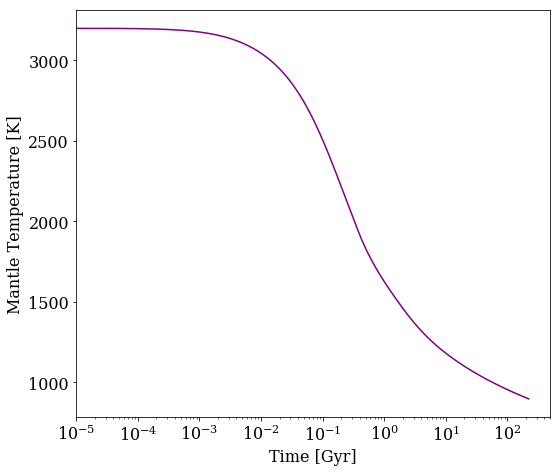

In [38]:
%matplotlib inline
fig = plt.figure(figsize=(8.5,7.5))
plt.semilogx(t_array_SS*2.22, T_array_SS*1600., color='purple')
#plt.semilogx(tmp_time_array_SS*2.22, tmp_temp_array_SS*1600., color='purple')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel('Mantle Temperature [K]', fontsize=16)

/Users/admin/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


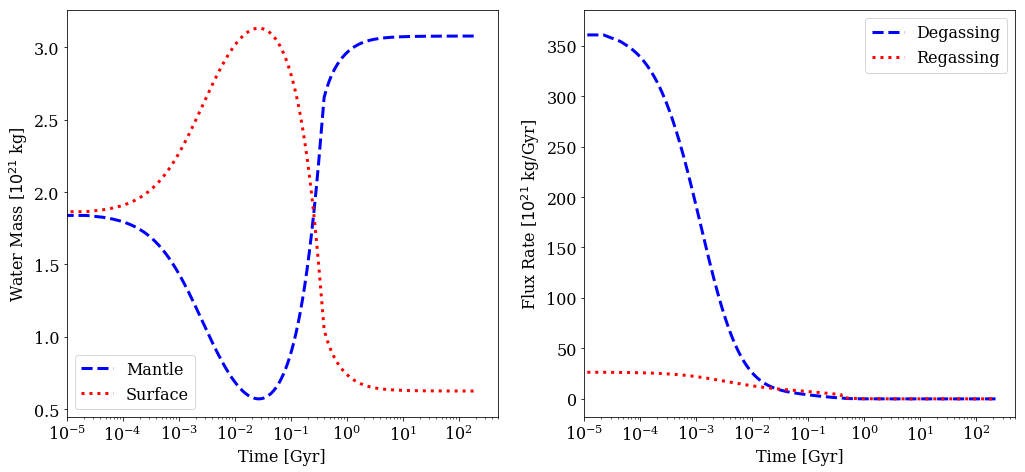

In [39]:
%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(17,7.5))
plt.tight_layout()
ax = [fig.add_subplot(1,2,i+1) for i in range(2)]
fig.subplots_adjust(hspace=0)

kg_conv = 2.3e-4*1.3*M_E #[kg]

ax = plt.subplot(1,2,1)
plt.semilogx(t_array_SS*2.22, (x_array_SS*kg_conv/1000./1.0e18), linewidth=3, color='b', linestyle='--', label='Mantle')
plt.semilogx(t_array_SS*2.22, (s_array_SS*kg_conv/1000./1.0e18), linewidth=3, color='r', linestyle=':', label='Surface')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel(r'Water Mass [$10^{21}$ kg]', fontsize=16)
plt.legend(loc='lower left', fontsize=16)

# Conversion factor for degassing and regassing to units: (mass transport flux in [kg m^-2 s^-1])
# Literature tends to list global degassing rates in [mol yr^-1]; others simply use [g yr^1]; CA paper used [kg yr^-1]
# 1 mol H2O = 18.01528 g = 0.01801528 kg; 1 yr = 31536000 s
# Maybe try (10^18 tons)/(10^6 yr) = exatons/Myr
# degassing: (kg_conv**2)/(9.8**2)... 
# regassing: (kg_conv**2)/(9.8**2)
dr_conv = (3*np.pi*(6.3781e6)*(0.1/31536000.)*0.05*3.0e3*0.23*3.0e3/0.68) #[kg/s]
mol_yr_conv = (3153600./0.01801528) # convert [kg/s] to [mol/yr]
exa_gyr_conv = (3153600.*1.0e9/(1000.*1.0e18)) # convert [kg/s] to [exatons/Gyr]
# Mol/yr rate consistent with degassing rate of H2O from paper -- 6*10^12 mol/yr!

ax = plt.subplot(1,2,2)
plt.semilogx(t_array_SS*2.22, (degas_array_SS*dr_conv*exa_gyr_conv), linewidth=3, color='b', linestyle='--', label='Degassing')
plt.semilogx(t_array_SS*2.22, (regas_array_SS*dr_conv*exa_gyr_conv), linewidth=3, color='r', linestyle=':', label='Regassing')
#plt.semilogx(t_array_SS*2.22, (loss_array_SS*dr_conv*exa_gyr_conv), linewidth=3, color='k', linestyle='-.', label='Atmospheric Loss')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel(r'Flux Rate [$10^{21}$ kg/Gyr]', fontsize=16)
#plt.ylim([-1, 5.])
plt.legend(loc='upper right', fontsize=16)
#plt.savefig('Recoded_SS_model_cycling_noloss.pdf', bbox_inches='tight')


# Hybrid Model, using scipy.integrate
## This is the quickest way to run through this cycling, so just code it this way from the beginning.

In [ ]:
# Many functions have already been defined for the SS model -- only define new things here.
rho_m = 3.3e3
d_melt = 60.0e3
f_degasE = 0.9
omega_0 = 2.3e-4
f_btwid = 1.3
f_M = 0.68
E = rho_m*d_melt*f_degasE*omega_0*f_btwid/f_M

def Etwid(M):
    rho_m = 3.3e3
    d_melt = 60.0e3
    f_degasE = 0.9
    omega_0 = 2.3e-4
    f_btwid = 1.3
    f_M = 0.68
    E = rho_m*d_melt*f_degasE*omega_0*f_btwid/f_M
    
    return E/D(M)

In [ ]:
# Define functions for change in 1) mantle temperature, 2) mantle water mass fraction, 3) surface water mass fraction.
def f_delta_temp_hyb(t_twid, temp_twid, x_twid, M):
    Q_0 = 5.0e-8
    rho_m = 3.3e3
    c_p = 1200.
    T_ref = 1600.
    #tau_heat = Q_0/(rho_m*c_p*T_ref)
    
    #tau_decay = 2.0e9*3.154e7
    tau_decay_twid = 2.0e9*3.154e7/(rho_m*c_p*T_ref/F_0(M))
    F_0twid = F_0(M)/Q_0
    beta = 0.3
    T_stwid = 280./1600.
    
    R_g = 8.314
    E_a = 335.0e3
    T_mtwid = T_ref*R_g/(E_a)
    #(tau_heat/tau(M))* on the first term?
    return ((1./F_0twid)*np.exp(-t_twid/tau_decay_twid)) - \
        ((f_wtwid(x_twid)**beta)*((temp_twid-T_stwid)**(beta+1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)))

def f_delta_x_hyb(t_twid, temp_twid, x_twid, s_twid, M):
        chi_d = 0.03
    chi_r = 0.02
    theta = 1.5 #melt fraction exponent
    gamma = 0.75
    E_a = 335.0e3
    R_g = 8.314
    T_ref = 1600.
    T_liq_dry = 1225.+273.15
    T_sol_dry = 975.+273.15
    T_liqtwid = T_liq_dry/T_ref
    T_soltwid = T_sol_dry/T_ref
    T_serp = 973.
    T_s = 280.
    T_stwid = 280./1600. #surface temperature
    T_mtwid = T_ref*R_g/(E_a) #another reference temperature
    K_cnst = 43.
    Ktwid = K_cnst/T_ref
    omega_0 = 2.3e-4
    f_btwid = 1.3
    f_M = 0.68
    lambdatwid = Ktwid*(omega_0*f_btwid/f_M)**(gamma)
    x_h = 0.05
    rho_m = 3.3e3
    rho_c = 3.0e3
    beta = 0.3
    kappa = 1.0e-6
    Ra_c = 1100.
    r_fug = 1.
    eta_scale = (np.exp(lnf_w(1.)))**(-r_fug)
    eta_0 = 1.0e21/eta_scale
    alpha = 2.0e-5
    d_melt = 60.0e3
    
    Pi = (rho_m*d_melt*chi_d*(omega_0*f_btwid/f_M)*((T_liqtwid-T_soltwid)**-theta))
    D_2 = (h(M)**(1.-3.*beta))*((T_serp-T_s)/(T_ref**(1.+beta)))*((kappa*Ra_c*eta_0)/(alpha*rho_m*g(M)*np.exp(lnf_w(1.))))**beta
    
    Pitwid_max = Pi/(D_2_max(temp_twid, x_twid, s_twid, M)*x_h*rho_c*chi_r)
    hydr_lhs = x_h*rho_m*(4.*np.pi/3.)*((Rp(M)**3.)-(Rp(M) - (D_2*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid(x_twid)**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))))**3.)
    hydr_rhs = M*omega_0*f_btwid*s_twid
    
    if x_twid > 0. and s_twid > 0.: #water in both reservoirs
        
        # Hydrated layer check
        if hydr_lhs <= hydr_rhs and s_twid > 0.: 
            return (f_wtwid(x_twid)**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                ((1./temp_twid)-1.))*x_twid*((temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)))**theta) - \
                (1./Pitwid(M))*(f_wtwid(x_twid)**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.))
        elif hydr_lhs > hydr_rhs and s_twid > 0.:
            return (f_wtwid(x_twid)**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                ((1./temp_twid)-1.))*x_twid*((temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)))**theta) - \
                (1./Pitwid_max)*(f_wtwid(x_twid)**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.))
        elif s_twid < 0:
            return (f_wtwid(x_twid)**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                ((1./temp_twid)-1.))*x_twid*((temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)))**theta) - 0.
            
    elif x_twid <= 0. and s_twid > 0.: #no degassing if no water in mantle
        # Solidus check not needed here, since no water in mantle in this case
        
        # Hydrated layer check
        if hydr_lhs <= hydr_rhs and s_twid > 0.: 
            return 0. - (1./Pitwid(M))*(f_wtwid(x_twid)**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.))
        elif hydr_lhs > hydr_rhs and s_twid > 0.:
            return 0. - (1./Pitwid_max)*(f_wtwid(x_twid)**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.))
        elif s_twid < 0:
            return 0. - 0.
        
    elif x_twid > 0. and s_twid <= 0: #no regassing if no water on surface (also no loss)
        
        # Solidus temperature check
        if temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)) > 0.: #normal cycling
        
        # No hydrated layer check needed if no water on surface
            return (f_wtwid(x_twid)**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                ((1./temp_twid)-1.))*x_twid*((temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)))**theta) - 0.
                
        else: #temperature below solidus temperature, degassing shuts off
            
            return 0. - 0.
        
    elif x_twid <= 0. and s_twid <= 0.: #no degassing, no regassing, no loss --> DESSICATED
        # no need for solidus temperature check or hydrated layer check if no water left on planet in any reservoirs
        return 0. - 0.

# Dimensionful Models (for Comparison)

In [ ]:
#DIMENSIONFUL FUNCTIONS, FOR USE IN THE DIMENSIONFUL MODELS.
#Only include ones that are changed when using dimensionful x, T, etc.

## WATER FUGACITY
def lnf_w(x): 
    c0 = -7.9859
    c1 = 4.3559
    c2 = -0.5742
    c3 = 0.0337
    B = 2.0e6
    mu_oliv = 153.31
    mu_wat = 18.01528
        
    ln_term = np.log((B*x*(mu_oliv/mu_wat))/(1.-(x*(mu_oliv/mu_wat))))
    
    return c0 + c1*ln_term + c2*ln_term**2. + c3*ln_term**3.

## MANTLE VISCOSITY
r_fug = 1.
eta_scale = (np.exp(lnf_w(1.*2.3e-4*1.3/0.68)))**(-r_fug)
eta_0 = 1.e21/eta_scale

def eta(x, T):
    E_a = 335.0e3
    R_g = 8.314
    r_fug = 1.
    eta_scale = (np.exp(lnf_w(1)))**(-r_fug)
    eta_0 = 1.e21/eta_scale
    
    f_w = np.exp(lnf_w(x))
    
    eta_scale = (np.exp(lnf_w(1.*2.3e-4*1.3/0.68)))**(-r_fug)
    eta_0 = 1.e21/eta_scale

    return eta_0 * (f_w**(-r_fug)) * np.exp((E_a/R_g)*((1./T) - (1./T_ref)))

def F_0(M):
    T_ref = 1600.
    beta = 0.3
    alpha = 2.0e-5 #coefficent of thermal expansion
    rho_m = 3.3e3
    Ra_c = 1100. #critical Rayleigh number
    kappa = 1.0e-6 #mantle thermal diffusivity
    r_fug = 1.
    eta_scale = (np.exp(lnf_w(1.*2.3e-4*1.3/0.68)))**(-r_fug)
    eta_0 = 1.e21/eta_scale

    f_w = np.exp(lnf_w(1.*2.3e-4*1.3/0.68))
    return (k*(T_ref**(1.+beta))*A(M)/(h(M)*V(M)))*(alpha*rho_m*g(M)*(h(M)**3.)*f_w/(Ra_c*kappa*eta_0))**beta

def S(T, x, M):
    kappa = 1.0e-6
    beta = 0.3
    alpha = 2.0e-5
    rho_m = 3.3e3
    T_s = 280.
    Ra_c = 1100.
        
    return 10.76*(kappa**(1.-2.*beta))*(h(M)**(6.*beta-1.))*((alpha*rho_m*g(M)*(T-T_s)/(eta(x,T)*Ra_c))**(2.*beta))

In [ ]:
%matplotlib inline
fig = plt.figure(figsize=(8.5,7.5))
plt.semilogx(t_array_SS*2.22, T_array_SS*1600., color='purple', linestyle='--')
plt.semilogx(tmp_time_array_SS*2.22, tmp_temp_array_SS*1600., color='purple')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel('Mantle Temperature [K]', fontsize=16)

# CA Model -- Dimensionful

## Try to code the dimensionful seafloor pressure-dependent model, see if I get the same results.

In [ ]:
#t_array_CA = np.arange(0., t_max, dt)  #time
#x_array_CA = np.zeros(int(t_max/dt)) #mantle water mass fraction
#s_array_CA = np.zeros(int(t_max/dt)) #surface water
#T_array_CA = np.zeros(int(t_max/dt)) #mantle temperature
#regas_array_CA = np.zeros(int(t_max/dt)) #regassing
#degas_array_CA = np.zeros(int(t_max/dt)) #degassing
#loss_array_SS = np.zeros(int(t_max/dt)) #loss to space #don't worry about this for now

# Initial values.
#M = M_E # Do the calculations for Earth's mass.
# x_E = xtwid_E*omega_0*f_btwid/f_M in paper.
# xtwid = omegatwid/2 = 1.035 used in simulations above.
#x_array_CA[0] = 1.5*(1.39e21/(M_E*f_M)) #50% of water starts in the mantle #1.5*1.39 # [10^21 kg] -- one Earth ocean is 1.39e21 kg
#s_array_CA[0] = 1.5*(1.39e21/M_E) #50% of water starts on the surface #1.5*1.39 # [10^21 kg]
#T_array_CA[0] = 2.*1600. # [K] -- this is 2 * T_ref, the initial condition of the non-dimensional model
#regas_array_CA[0] = 
#degas_array_CA[0] = 

# SS Model -- Dimensionful
## Check if using the dimensionful model can match Tad's results.
## Then add loss.

In [ ]:
# Define functions from equation (45).

# Constants first.
g = 9.8 #Earth gravity [m/s^2]
K_cnst = 43. #(in f_melt) 
T_liq_dry = 1225.+273.15 #dry liquidus temperature [K]
T_sol_dry = 975.+273.15 #dry solidus temperature [K]
T_serp = 973. #[K]
T_s = 280. #surface temperature [K]
gamma = 0.75 #solidus depression coefficient
kappa = 1.e-6 #mantle thermal diffusivity
alpha = 2.e-5
beta = 0.3
Ra_c = 1100. #critical Rayleigh number
rho_m = 3.3e3
theta = 1.5 #melt fraction exponent
tau_decay = 2.0e9*year #radionuclide decay time [s]
Q_0 = 5.e-8 #heating rate constant
M_E = 5.972e24 #Earth mass [kg]
R_E = 6.371e6 #Earth radius [m]
G = 6.67e-11 #gravitational constant
k = 4.2 #(in conducted heat flux, F_cond)
beta = 0.3 #(exponent in many equations)
chi_d = 0.03 #degassing efficiency
chi_r = 0.02 #regassing efficiency
year = 3.154e7 #seconds per year

def S(T, x, M):
    return 10.76*(kappa**(1.-2.*beta))*(h(M)**(6.*beta-1.))*((alpha*rho_m*g(M)*(T-T_s)/(eta(T,x)*Ra_c))**(2.*beta))

def d_h(T, x, M):
    return (h(M)**(1.-3.*beta))*((T-T_s)**(-(1.+beta)))*(T_serp-T_s)*((eta(T,x)*kappa*Ra_c/(alpha*rho_m*g(M)))**beta)

def T_sol_wet(x):
    return T_sol_dry - K_cnst*(x**gamma)

def f_melt(T, x):
    return ((T - T_sol_wet(x))/(T_liq_dry - T_sol_dry))**theta

# Temperature equations.
def Q(t): #t in SECONDS
    return Q_0*np.exp(-t/tau_decay)

def F(T, x, M):
    a = 1. #based on assumptions in paper
    del_T = T - T_s #temperature constrast across boundary layer
    return (k*del_T/h(M))*a*((alpha*rho_m*g(M)*del_T*(h(M)**3.))/(eta(T,x)*kappa*Ra_c))**beta

In [ ]:
M = M_E
eta_0 = 9.03e24
Q_0 = 5.0e-8
f_w = np.exp(lnf_w(1.))
F_0 = (k*(T_ref**(1.+beta))*A(M)/(h(M)*V(M)))*(alpha*rho_m*g(M)*(h(M)**3.)*f_w/(Ra_c*kappa*eta_0))**beta
print(F_0/Q_0)

In [ ]:
# Set initial conditions, dimensionful.

# Time goes to 200 Gyr.
# Timestep -- start large and reduce if the cycling seems too large.
dt = 2.0e-5 #years
t_max = 200. #years

# Create arrays for plotting. 
t_array_SS = np.arange(0., t_max, dt)  #time
x_array_SS = np.zeros(int(t_max/dt)) #mantle water mass fraction
s_array_SS = np.zeros(int(t_max/dt)) #surface water
T_array_SS = np.zeros(int(t_max/dt)) #mantle temperature
regas_array_SS = np.zeros(int(t_max/dt)) #regassing
degas_array_SS = np.zeros(int(t_max/dt)) #degassing
#loss_array_SS = np.zeros(int(t_max/dt)) #loss to space #don't worry about this for now

# Initial values.
M = M_E # Do the calculations for Earth's mass.
# x_E = xtwid_E*omega_0*f_btwid/f_M in paper.
# xtwid = omegatwid/2 = 1.035 used in simulations above.
x_array_SS[0] = 1.5*(1.39e21/(M_E*f_M)) #50% of water starts in the mantle #1.5*1.39 # [10^21 kg] -- one Earth ocean is 1.39e21 kg
s_array_SS[0] = 1.5*(1.39e21/M_E) #50% of water starts on the surface #1.5*1.39 # [10^21 kg]
T_array_SS[0] = 2.*1600. # [K] -- this is 2 * T_ref, the initial condition of the non-dimensional model
regas_array_SS[0] = (x_h*rho_c*chi_r*d_h(T_array_SS[0], x_array_SS[0], M))
degas_array_SS[0] = (rho_m*d_melt*chi_d*f_melt(T_array_SS[0], x_array_SS[0])*x_array_SS[0])

In [ ]:
# Run the cycling.

for idx in range(1, len(t_array_SS)):
    
    # Calculate new water mass fraction and surface mass fraction.
# XXXX IDEALLY, REGASSING RATES SHOULD DEPEND ON SURFACE WATER CONTENT (I.E., NON-CONSTANT x_h) XXXX
    x_array_SS[idx] = x_array_SS[idx-1] + (L_MOR(M)*S(T_array_SS[idx-1], x_array_SS[idx-1], M)/(f_M*M))*(regas_array_SS[idx-1] - degas_array_SS[idx-1])*dt
    s_array_SS[idx] = s_array_SS[idx-1] + (L_MOR(M)*S(T_array_SS[idx-1], x_array_SS[idx-1], M)/M)*(degas_array_SS[idx-1] - regas_array_SS[idx-1])*dt
    
    # Check if they go to zero.
    if x_array_SS[idx] <= 0.:
        x_array_SS[idx] = 0.
    if s_array_SS[idx] <= 0.:
        s_array_SS[idx] = 0.
        
    # Calculate new mantle temperature.  XXX SHOULD I USE PREVIOUS TIMESTEP, OR CURRENT ONE?
    T_array_SS[idx] = T_array_SS[idx-1] + (1./(rho_m*c_p))*(Q(t_array_SS[idx-1]*year) - \
        ((A(M)*F(T_array_SS[idx-1], x_array_SS[idx-1], M))/V(M)))*dt
    
    # XXX TO ADD -- HYDRATED LAYER DEPTH CHECK, SOLIDUS TEMPERATURE CHECK. XXX
    # 1) Force hydrated layer to hold no more water than the surface itself.
    # 2) If mantle temperature falls below the solidus temperature, degassing shuts off (important at late times).
    
    # Calculate new regassing, degassing, and loss fluxes.
    if x_array_SS[idx] > 0. and s_array_SS[idx] > 0.: #water in both reservoirs
        regas_array_SS[idx] = (x_h*rho_c*chi_r*d_h(T_array_SS[idx], x_array_SS[idx], M))
        degas_array_SS[idx] = (rho_m*d_melt*chi_d*f_melt(T_array_SS[idx], x_array_SS[idx])*x_array_SS[idx])
        #loss_array_SS[idx] = loss_factor*np.exp(-t_array_CA[idx]/t_loss)
    elif x_array_SS[idx] <= 0. and s_array_SS[idx] > 0.: #no degassing if no water in mantle
        regas_array_SS[idx] = (x_h*rho_c*chi_r*d_h(T_array_SS[idx], x_array_SS[idx], M))
        degas_array_SS[idx] = 0.
        #loss_array_SS[idx] = loss_factor*np.exp(-t_array_CA[idx]/t_loss) # OR const_loss
    elif x_array_SS[idx] > 0. and s_array_SS[idx] <= 0: #no regassing if no water on surface (also no loss)
        regas_array_SS[idx] = 0.
        degas_array_SS[idx] = (rho_m*d_melt*chi_d*f_melt(T_array_SS[idx], x_array_SS[idx])*x_array_SS[idx])
       #loss_array_SS[idx] = 0.
    elif x_array_SS[idx] <= 0. and s_array_SS[idx] <= 0.: #no degassing, no regassing, no loss --> DESSICATED
        regas_array_SS[idx] = 0.
        degas_array_SS[idx] = 0.
        #loss_array_SS[idx] = 0.

In [ ]:
print(x_array_SS[0], s_array_SS[0], T_array_SS[0])
print(x_array_SS[-1], s_array_SS[-1], T_array_SS[-1])
print(degas_array_SS[0], regas_array_SS[0])
print(degas_array_SS[-1], regas_array_SS[-1])
# XXXX CHECK IF THESE VALUES MATCH THE DESCRIPTION OF REGASSING/DEGASSING RATES IN PAPER TABLE 2? XXXX

In [ ]:
print(T_array_SS[0])
print((1./(rho_m*c_p))*(Q(t_array_SS[0]) - (A(M)*F(T_array_SS[0], x_array_SS[0], M)/V(M)))*dt)
print(rho_m, c_p, Q(t_array_SS[0]), A(M), F(T_array_SS[0], x_array_SS[0], M), V(M))

In [ ]:
%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(17,7.5))
plt.tight_layout()
ax = [fig.add_subplot(1,2,i+1) for i in range(2)]
fig.subplots_adjust(hspace=0)

ax = plt.subplot(1,2,1)
plt.semilogx(t_array_SS*2.22, x_array_SS*f_M*M_E, linewidth=3, color='b', linestyle='--', label='Mantle')
plt.semilogx(t_array_SS*2.22, s_array_SS*M_E, linewidth=3, color='r', linestyle=':', label='Surface')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel(r'Water Mass [$10^{21}$ kg]', fontsize=16)
plt.legend(loc='lower left', fontsize=16)

# Conversion factor for degassing and regassing to units: (mass transport flux in [kg m^-2 s^-1])
# Literature tends to list global degassing rates in [mol yr^-1]; others simply use [g yr^1]; CA paper used [kg yr^-1]
# 1 mol H2O = 18.01528 g = 0.01801528 kg; 1 yr = 31536000 s
# Maybe try (10^18 tons)/(10^6 yr) = exatons/Myr
# degassing: (kg_conv**2)/(9.8**2)... 
# regassing: (kg_conv**2)/(9.8**2)
dr_conv = (3*np.pi*(6.3781e6)*(0.1/31536000.)*0.05*3.0e3*0.23*3.0e3/0.68) #[kg/s]
mol_yr_conv = (3153600./0.01801528) # convert [kg/s] to [mol/yr]
exa_gyr_conv = (3153600.*1.0e9/(1000.*1.0e18)) # convert [kg/s] to [exatons/Gyr]
# Mol/yr rate consistent with degassing rate of H2O from paper -- 6*10^12 mol/yr!

# XXX FIGURE OUT THE CONVERSION HERE XXX
ax = plt.subplot(1,2,2)
plt.semilogx(t_array_SS*2.22, degas_array_SS, linewidth=3, color='b', linestyle='--', label='Degassing')
plt.semilogx(t_array_SS*2.22, regas_array_SS, linewidth=3, color='r', linestyle=':', label='Regassing')
#plt.semilogx(t_array_SS*2.22, (loss_array_SS*dr_conv*exa_gyr_conv), linewidth=3, color='k', linestyle='-.', label='Atmospheric Loss')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel(r'Flux Rate [$10^{21}$ kg/Gyr]', fontsize=16)
#plt.ylim([-0.1, 5.])
plt.legend(loc='upper right', fontsize=16)
#plt.savefig('Recoded_SS_model_cycling_noloss.pdf', bbox_inches='tight')

In [ ]:
%matplotlib inline
fig = plt.figure(figsize=(8.5,7.5))
plt.semilogx(t_array_SS, T_array_SS, color='purple')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel('Mantle Temperature [K]', fontsize=16)

In [ ]:
## 